# Marchantia modelling

### Import packages and functions

In [1]:
import cobra
from cobra import Reaction, Metabolite
from matplotlib import pyplot as plt, patches
import pandas as pd
import numpy as np
import re
import random
from cobra.flux_analysis import flux_variability_analysis

plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_3085/2423951844.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
cobra.__version__

'0.26.3'

In [3]:
# set solver for optimisation
solver = 'glpk'
cobra.core.Configuration.solver = solver


In [4]:
%run FBA_model_functions.ipynb

In [5]:
# [(sheet name without bounds, sheet name with bounds), CO2 assim. rate, [min CO2 assim. rate, max CO2 assim. rate], growth rate, [min growth rate, max growth rate]]

dataset_dict = {
"Arabidopsis_1": [("Arabi._1", "Arabi._1_ub"), 4.08, [3.37,4.74], 0.393, [0.393,0.596]],
"Arabidopsis_2": [("Arabi._2", "Arabi._2_ub"), 3.37, [3.37,4.74], 0.409, [0.393,0.596]],
"Arabidopsis_3": [("Arabi._3", "Arabi._3_ub"), 3.8, [3.37,4.74], 0.596, [0.393,0.596]],
"Arabidopsis_4": [("Arabi._4", "Arabi._4_ub"), 4.74, [3.37,4.74], 0.587, [0.393,0.596]],
"Marchantia_1": [("March_1", "March_1_ub_stdev"), 1.16, [0.794,1.86], 0.238, [0.0998,0.291]],
"Marchantia_2": [("March_2", "March_2_ub_stdev"), 0.794, [0.794,1.86], 0.0998, [0.0998,0.291]],
"Marchantia_3": [("March_3", "March_3_ub_stdev"), 1.86, [0.794,1.86], 0.208957005, [0.12, 0.291]],
"Marchantia_Naomi_1": [("Naomis_modelling_setup_1", ""), 1.16, [], 0.238, []],
"Marchantia_Naomi_2": [("Naomis_modelling_setup_2", ""), 0.794, [], 0.0998, []]}

## Chapter 1) Recreating Naomi's model

### Model Setup

#### Arabidopsis model setup

##### loading model, adding reactions and metabolites for extra biomass components

- use v2_1_0 version of core model (as I don't have Naomi's Arabidopsis model version)
- add the same metabolites and reactions that Naomi added to the Marchantia model, as some of the biomass components listed in her table for Arabidopsis also wouldn't be produced if these weren't present

In [6]:
# core plant metabolism model
cobra_model = cobra.io.read_sbml_model("PlantCoreMetabolism_v2_1_0.xml")

In [7]:
# adding 57 metabolites
met_list = ['9Z12Z15Z_HEXADECATRIENOATE_p',
 '9Z12Z15Z_HEXADECATRIENOATE_c',
 '9Z12Z15Z_HEXADECATRIENOATE_x',
 'UDP_D_GALACTURONATE_c',
 '1_4_ALPHA_D_GALACTURONOSYL_c',
 'METHYL_ESTERIFIED_HOMOGALACTURONAN_c',
 'HOMOGALACTURONAN_b',
 'OLEOYL_COA_p',
 'A_GLYCEROLIPID_p',
 'A_GLYCEROLIPID_OLEATE_p',
 'A_GLYCEROLIPID_LINOLEATE_p',
 'CPD_18_p',
 'A_GLYCEROLIPID_GAMMA_LINOLENATE_p',
 'GAMMA_LINOLENOYL_COA_p',
 'GAMMA_LINOLENATE_p',
 'CPD_14404_p',
 'CPD_14405_p',
 'CPD_14406_p',
 'CPD_14407_p',
 'CPD_8120_p',
 'CPD_8120_c',
 'CPD_8120_b',
 'CPD_17283_p',
 'CPD_17284_p',
 'ARACHIDONYL_COA_p',
 'ARACHIDONIC_ACID_p',
 'ARACHIDONIC_ACID_c',
 'ARACHIDONIC_ACID_b',
 'A_GLYCEROLIPID_ALPHA_LINOLENATE_p',
 'CPD_17278_p',
 'CPD_14392_p',
 'CPD_17262_p',
 'CPD_17263_p',
 'CPD_17264_p',
 'CPD_14394_p',
 'CPD_17281_p',
 'CPD_17282_p',
 'CPD_14018_p',
 '5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p',
 '5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c',
 '5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_b',
 'A_GLYCEROLIPID_PALMITATE_p',
 'CPD_17294_p',
 'CPD_17293_p',
 'CPD_17292_p',
 'HEXADECATRIENOYL_COA_p',
 'HEXADECADIENOYL_COA_p',
 'CPD_17291_b',
 'CPD_17290_p',
 'CPD_17290_c',
 'CPD_17290_b',
 'PALMITATE_b',
 'CPD_9245_b',
 'STEARIC_ACID_b',
 'OLEATE_CPD_b',
 'Octadecadienoate_b',
 'LINOLENIC_ACID_b']

M_9Z12Z15Z_HEXADECATRIENOATE_p = Metabolite("9Z12Z15Z_HEXADECATRIENOATE_p", name = "9Z12Z15Z_HEXADECATRIENOATE_p", compartment ="p", charge = None)
cobra_model.add_metabolites(M_9Z12Z15Z_HEXADECATRIENOATE_p)

M_9Z12Z15Z_HEXADECATRIENOATE_c = Metabolite("9Z12Z15Z_HEXADECATRIENOATE_c", name = "9Z12Z15Z_HEXADECATRIENOATE_c", compartment ="c", charge = -1)
cobra_model.add_metabolites(M_9Z12Z15Z_HEXADECATRIENOATE_c)

M_9Z12Z15Z_HEXADECATRIENOATE_x = Metabolite("9Z12Z15Z_HEXADECATRIENOATE_x", name = "9Z12Z15Z_HEXADECATRIENOATE_x", compartment ="x", charge = -1)
cobra_model.add_metabolites(M_9Z12Z15Z_HEXADECATRIENOATE_x)

M_UDP_D_GALACTURONATE_c = Metabolite("UDP_D_GALACTURONATE_c", name = "UDP_D_GALACTURONATE_c", compartment ="c", charge = 0)
cobra_model.add_metabolites(M_UDP_D_GALACTURONATE_c)

M_1_4_ALPHA_D_GALACTURONOSYL_c = Metabolite("1_4_ALPHA_D_GALACTURONOSYL_c", name = "1_4_ALPHA_D_GALACTURONOSYL_c", compartment ="c", charge = 0)
cobra_model.add_metabolites(M_1_4_ALPHA_D_GALACTURONOSYL_c)

M_METHYL_ESTERIFIED_HOMOGALACTURONAN_c = Metabolite("METHYL_ESTERIFIED_HOMOGALACTURONAN_c", name = "METHYL_ESTERIFIED_HOMOGALACTURONAN_c", compartment ="c", charge = 0)
cobra_model.add_metabolites(M_METHYL_ESTERIFIED_HOMOGALACTURONAN_c)

M_HOMOGALACTURONAN_b = Metabolite("HOMOGALACTURONAN_b", name = "HOMOGALACTURONAN_b", compartment ="b", charge = 0)
cobra_model.add_metabolites(M_HOMOGALACTURONAN_b)

M_OLEOYL_COA_p = Metabolite("OLEOYL_COA_p", name = "OLEOYL_COA_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_OLEOYL_COA_p)

M_A_GLYCEROLIPID_p = Metabolite("A_GLYCEROLIPID_p", name = "A_GLYCEROLIPID_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_A_GLYCEROLIPID_p)

M_A_GLYCEROLIPID_OLEATE_p = Metabolite("A_GLYCEROLIPID_OLEATE_p", name = "A_GLYCEROLIPID_OLEATE_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_A_GLYCEROLIPID_OLEATE_p)

M_A_GLYCEROLIPID_LINOLEATE_p = Metabolite("A_GLYCEROLIPID_LINOLEATE_p", name = "A_GLYCEROLIPID_LINOLEATE_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_A_GLYCEROLIPID_LINOLEATE_p)

M_CPD_18_p = Metabolite("CPD_18_p", name = "CPD_18_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_18_p)

M_A_GLYCEROLIPID_GAMMA_LINOLENATE_p = Metabolite("A_GLYCEROLIPID_GAMMA_LINOLENATE_p", name = "A_GLYCEROLIPID_GAMMA_LINOLENATE_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_A_GLYCEROLIPID_GAMMA_LINOLENATE_p)

M_GAMMA_LINOLENOYL_COA_p = Metabolite("GAMMA_LINOLENOYL_COA_p", name = "GAMMA_LINOLENOYL_COA_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_GAMMA_LINOLENOYL_COA_p)

M_GAMMA_LINOLENATE_p = Metabolite("GAMMA_LINOLENATE_p", name = "GAMMA_LINOLENATE_p", compartment ="p", charge = -1)
cobra_model.add_metabolites(M_GAMMA_LINOLENATE_p)

M_CPD_14404_p = Metabolite("CPD_14404_p", name = "CPD_14404_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14404_p)

M_CPD_14405_p = Metabolite("CPD_14405_p", name = "CPD_14405_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14405_p)

M_CPD_14406_p = Metabolite("CPD_14406_p", name = "CPD_14406_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14406_p)

M_CPD_14407_p = Metabolite("CPD_14407_p", name = "CPD_14407_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14407_p)

M_CPD_8120_p = Metabolite("CPD_8120_p", name = "CPD_8120_p", compartment ="p", charge = -1)
cobra_model.add_metabolites(M_CPD_8120_p)

M_CPD_8120_c = Metabolite("CPD_8120_c", name = "CPD_8120_c", compartment ="c", charge = -1)
cobra_model.add_metabolites(M_CPD_8120_c)

M_CPD_8120_b = Metabolite("CPD_8120_b", name = "CPD_8120_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_CPD_8120_b)

M_CPD_17283_p = Metabolite("CPD_17283_p", name = "CPD_17283_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17283_p)

M_CPD_17284_p = Metabolite("CPD_17284_p", name = "CPD_17284_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17284_p)

M_ARACHIDONYL_COA_p = Metabolite("ARACHIDONYL_COA_p", name = "ARACHIDONYL_COA_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_ARACHIDONYL_COA_p)

M_ARACHIDONIC_ACID_p = Metabolite("ARACHIDONIC_ACID_p", name = "ARACHIDONIC_ACID_p", compartment ="p", charge = -1)
cobra_model.add_metabolites(M_ARACHIDONIC_ACID_p)

M_ARACHIDONIC_ACID_c = Metabolite("ARACHIDONIC_ACID_c", name = "ARACHIDONIC_ACID_c", compartment ="c", charge = -1)
cobra_model.add_metabolites(M_ARACHIDONIC_ACID_c)

M_ARACHIDONIC_ACID_b = Metabolite("ARACHIDONIC_ACID_b", name = "ARACHIDONIC_ACID_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_ARACHIDONIC_ACID_b)

M_A_GLYCEROLIPID_ALPHA_LINOLENATE_p = Metabolite("A_GLYCEROLIPID_ALPHA_LINOLENATE_p", name = "A_GLYCEROLIPID_ALPHA_LINOLENATE_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_A_GLYCEROLIPID_ALPHA_LINOLENATE_p)

M_CPD_17278_p = Metabolite("CPD_17278_p", name = "CPD_17278_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17278_p)

M_CPD_14392_p = Metabolite("CPD_14392_p", name = "CPD_14392_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14392_p)

M_CPD_17262_p = Metabolite("CPD_17262_p", name = "CPD_17262_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_17262_p)

M_CPD_17263_p = Metabolite("CPD_17263_p", name = "CPD_17263_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_17263_p)

M_CPD_17264_p = Metabolite("CPD_17264_p", name = "CPD_17264_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_17264_p)

M_CPD_14394_p = Metabolite("CPD_14394_p", name = "CPD_14394_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14394_p)

M_CPD_17281_p = Metabolite("CPD_17281_p", name = "CPD_17281_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17281_p)

M_CPD_17282_p = Metabolite("CPD_17282_p", name = "CPD_17282_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17282_p)

M_CPD_14018_p = Metabolite("CPD_14018_p", name = "CPD_14018_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14018_p)

M_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p = Metabolite("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p", name = "5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p", compartment ="p", charge = -1)
cobra_model.add_metabolites(M_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p)

M_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c = Metabolite("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c", name = "5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c", compartment ="c", charge = -1)
cobra_model.add_metabolites(M_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c)

M_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_b = Metabolite("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_b", name = "5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_b)

M_A_GLYCEROLIPID_PALMITATE_p = Metabolite("A_GLYCEROLIPID_PALMITATE_p", name = "A_GLYCEROLIPID_PALMITATE_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_A_GLYCEROLIPID_PALMITATE_p)

M_CPD_17294_p = Metabolite("CPD_17294_p", name = "CPD_17294_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17294_p)

M_CPD_17293_p = Metabolite("CPD_17293_p", name = "CPD_17293_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17293_p)

M_CPD_17292_p = Metabolite("CPD_17292_p", name = "CPD_17292_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17292_p)

M_HEXADECATRIENOYL_COA_p = Metabolite("HEXADECATRIENOYL_COA_p", name = "HEXADECATRIENOYL_COA_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_HEXADECATRIENOYL_COA_p)

M_HEXADECADIENOYL_COA_p = Metabolite("HEXADECADIENOYL_COA_p", name = "HEXADECADIENOYL_COA_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_HEXADECADIENOYL_COA_p)

M_CPD_17291_b = Metabolite("CPD_17291_b", name = "CPD_17291_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_CPD_17291_b)

M_CPD_17290_p = Metabolite("CPD_17290_p", name = "CPD_17290_p", compartment ="p", charge = -1)
cobra_model.add_metabolites(M_CPD_17290_p)

M_CPD_17290_c = Metabolite("CPD_17290_c", name = "CPD_17290_c", compartment ="c", charge = -1)
cobra_model.add_metabolites(M_CPD_17290_c)

M_CPD_17290_b = Metabolite("CPD_17290_b", name = "CPD_17290_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_CPD_17290_b)

M_PALMITATE_b = Metabolite("PALMITATE_b", name = "PALMITATE_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_PALMITATE_b)

M_CPD_9245_b = Metabolite("CPD_9245_b", name = "CPD_9245_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_CPD_9245_b)

M_STEARIC_ACID_b = Metabolite("STEARIC_ACID_b", name = "STEARIC_ACID_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_STEARIC_ACID_b)

M_OLEATE_CPD_b = Metabolite("OLEATE_CPD_b", name = "OLEATE_CPD_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_OLEATE_CPD_b)

M_Octadecadienoate_b = Metabolite("Octadecadienoate_b", name = "Octadecadienoate_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_Octadecadienoate_b)

M_LINOLENIC_ACID_b = Metabolite("LINOLENIC_ACID_b", name = "LINOLENIC_ACID_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_LINOLENIC_ACID_b)

In [8]:
# adding 60 reactions
rxn_list = ['palmitoyl_ACP_desaturase_p',
 '9Z12Z15Z_HEXADECATRIENOATE_pc',
 '9Z12Z15Z_HEXADECATRIENOATE_xc',
 'Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x',
 'UDP_GLUCURONATE_4_EPIMERASE_RXN_c',
 '2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c',
 'RXN_2081_c',
 'HOMOGALACTURONAN_BIOMASS_c',
 'RXN_9644_p',
 'RXN_9670_p',
 'M_RXN_16036_p',
 'M_RXN_16045_p',
 'M_LINOLEOYL_RXN_p',
 'RXN_8343_p',
 'RXN_16043_p',
 'GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p',
 'RXN_12777_p',
 'RXN_12968_p',
 'RXN_12969_p',
 'RXN_12971_p',
 'di_homo_gamma_linolenate_biosynthesis_p',
 'RXN_16044_p',
 'RXN_8346_p',
 'arachidonate_transfer_rxn_p',
 'arachidonate_biosynthesis_p',
 'RXN_9667_p',
 'RXN_8347_p',
 'RXN_16041_p',
 'RXN_16019_p',
 'RXN_16020_p',
 'RXN_16021_p',
 'RXN_16022_p',
 'RXN_16042_p',
 'RXN_8350_p',
 'RXN_17688_p',
 'icosapentaenate_biosynthesis_p',
 'RXN_9623_SP_p',
 'palmitate_transfer_rxn_p',
 'RXN_16048_p',
 'RXN_16047_p',
 'RXN_16049_p',
 'hexadecadienoate_transfer_rxn_p',
 '7Z10Z_hexadecadienoate_biosynthesis_p',
 'hexadecatrienoate_transfer_rxn_p',
 '7Z10Z13Z_hexadecatrienoate_biosynthesis_p',
 'palmitate_biomass_2',
 'palmitoleate_biomass',
 '7Z10Z13Z_hexadecatrienoate_biomass',
 'CPD_17290_pc',
 '7Z10Z_hexadecadienoate_biomass',
 'stearate_biomass',
 'oleate_biomass',
 'alpha_linolenate_biomass',
 'CPD_8120_pc',
 'dihomo_gamma_linolenate_biomass',
 'octadecadienoate_biomass',
 'ARACHIDONIC_ACID_pc',
 'arachidonate_biomass',
 '5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc',
 'eicosapentaenoate_biomass']

R_palmitoyl_ACP_desaturase_p = Reaction("palmitoyl_ACP_desaturase_p")
R_palmitoyl_ACP_desaturase_p.upper_bound = 1000.0
R_palmitoyl_ACP_desaturase_p.lower_bound = 0.0
R_palmitoyl_ACP_desaturase_p.add_metabolites({
cobra_model.metabolites.get_by_id("Palmitoyl_ACPs_p"):-1.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0,
cobra_model.metabolites.get_by_id("Palmitoleoyl_ACP_p"):1.0})
cobra_model.add_reactions([R_palmitoyl_ACP_desaturase_p])


R_9Z12Z15Z_HEXADECATRIENOATE_pc = Reaction("9Z12Z15Z_HEXADECATRIENOATE_pc")
R_9Z12Z15Z_HEXADECATRIENOATE_pc.upper_bound = 1000.0
R_9Z12Z15Z_HEXADECATRIENOATE_pc.lower_bound = -1000.0
R_9Z12Z15Z_HEXADECATRIENOATE_pc.add_metabolites({
cobra_model.metabolites.get_by_id("9Z12Z15Z_HEXADECATRIENOATE_p"):-1.0,
cobra_model.metabolites.get_by_id("9Z12Z15Z_HEXADECATRIENOATE_c"):1.0})
cobra_model.add_reactions([R_9Z12Z15Z_HEXADECATRIENOATE_pc])


R_9Z12Z15Z_HEXADECATRIENOATE_xc = Reaction("9Z12Z15Z_HEXADECATRIENOATE_xc")
R_9Z12Z15Z_HEXADECATRIENOATE_xc.upper_bound = 1000.0
R_9Z12Z15Z_HEXADECATRIENOATE_xc.lower_bound = -1000.0
R_9Z12Z15Z_HEXADECATRIENOATE_xc.add_metabolites({
cobra_model.metabolites.get_by_id("9Z12Z15Z_HEXADECATRIENOATE_x"):-1.0,
cobra_model.metabolites.get_by_id("9Z12Z15Z_HEXADECATRIENOATE_c"):1.0})
cobra_model.add_reactions([R_9Z12Z15Z_HEXADECATRIENOATE_xc])


R_Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x = Reaction("Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x")
R_Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x.upper_bound = 1000.0
R_Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x.lower_bound = 0.0
R_Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x.add_metabolites({
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_x"):-4.0,
cobra_model.metabolites.get_by_id("NAD_x"):-7.0,
cobra_model.metabolites.get_by_id("aATP_x"):-0.35,
cobra_model.metabolites.get_by_id("ATP_x"):-0.65,
cobra_model.metabolites.get_by_id("9Z12Z15Z_HEXADECATRIENOATE_x"):-1.0,
cobra_model.metabolites.get_by_id("WATER_x"):-7.0,
cobra_model.metabolites.get_by_id("CO_A_x"):-8.0,
cobra_model.metabolites.get_by_id("AMP_x"):1.0,
cobra_model.metabolites.get_by_id("aPPI_x"):0.35,
cobra_model.metabolites.get_by_id("PPI_x"):0.65,
cobra_model.metabolites.get_by_id("HYDROGEN_PEROXIDE_x"):4.0,
cobra_model.metabolites.get_by_id("PROTON_x"):7.0,
cobra_model.metabolites.get_by_id("NADH_x"):7.0,
cobra_model.metabolites.get_by_id("ACETYL_COA_x"):8.0})
cobra_model.add_reactions([R_Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x])


R_UDP_GLUCURONATE_4_EPIMERASE_RXN_c = Reaction("UDP_GLUCURONATE_4_EPIMERASE_RXN_c")
R_UDP_GLUCURONATE_4_EPIMERASE_RXN_c.upper_bound = 1000.0
R_UDP_GLUCURONATE_4_EPIMERASE_RXN_c.lower_bound = 0.0
R_UDP_GLUCURONATE_4_EPIMERASE_RXN_c.add_metabolites({
cobra_model.metabolites.get_by_id("UDP_GLUCURONATE_c"):-1.0,
cobra_model.metabolites.get_by_id("UDP_D_GALACTURONATE_c"):1.0})
cobra_model.add_reactions([R_UDP_GLUCURONATE_4_EPIMERASE_RXN_c])


R_2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c = Reaction("2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c")
R_2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c.upper_bound = 1000.0
R_2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c.lower_bound = 0.0
R_2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c.add_metabolites({
cobra_model.metabolites.get_by_id("UDP_D_GALACTURONATE_c"):-1.0,
cobra_model.metabolites.get_by_id("1_4_ALPHA_D_GALACTURONOSYL_c"):1.0,
cobra_model.metabolites.get_by_id("UDP_c"):0.5,
cobra_model.metabolites.get_by_id("aUDP_c"):0.5})
cobra_model.add_reactions([R_2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c])


R_RXN_2081_c = Reaction("RXN_2081_c")
R_RXN_2081_c.upper_bound = 1000.0
R_RXN_2081_c.lower_bound = 0.0
R_RXN_2081_c.add_metabolites({
cobra_model.metabolites.get_by_id("1_4_ALPHA_D_GALACTURONOSYL_c"):-1.0,
cobra_model.metabolites.get_by_id("S_ADENOSYLMETHIONINE_c"):-1.0,
cobra_model.metabolites.get_by_id("METHYL_ESTERIFIED_HOMOGALACTURONAN_c"):1.0,
cobra_model.metabolites.get_by_id("ADENOSYL_HOMO_CYS_c"):1.0,
cobra_model.metabolites.get_by_id("PROTON_c"):1.0})
cobra_model.add_reactions([R_RXN_2081_c])


R_HOMOGALACTURONAN_BIOMASS_c = Reaction("HOMOGALACTURONAN_BIOMASS_c")
R_HOMOGALACTURONAN_BIOMASS_c.upper_bound = 1000.0
R_HOMOGALACTURONAN_BIOMASS_c.lower_bound = 0.0
R_HOMOGALACTURONAN_BIOMASS_c.add_metabolites({
cobra_model.metabolites.get_by_id("1_4_ALPHA_D_GALACTURONOSYL_c"):-0.2,
cobra_model.metabolites.get_by_id("METHYL_ESTERIFIED_HOMOGALACTURONAN_c"):-0.8,
cobra_model.metabolites.get_by_id("HOMOGALACTURONAN_b"):1.0})
cobra_model.add_reactions([R_HOMOGALACTURONAN_BIOMASS_c])


R_RXN_9644_p = Reaction("RXN_9644_p")
R_RXN_9644_p.upper_bound = 1000.0
R_RXN_9644_p.lower_bound = 0.0
R_RXN_9644_p.add_metabolites({
cobra_model.metabolites.get_by_id("OLEATE_CPD_p"):-1.0,
cobra_model.metabolites.get_by_id("ATP_p"):-0.9,
cobra_model.metabolites.get_by_id("aATP_p"):-0.1,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("AMP_p"):1.0,
cobra_model.metabolites.get_by_id("PPI_p"):0.55,
cobra_model.metabolites.get_by_id("bPPI_p"):0.45,
cobra_model.metabolites.get_by_id("OLEOYL_COA_p"):1.0})
cobra_model.add_reactions([R_RXN_9644_p])


R_RXN_9670_p = Reaction("RXN_9670_p")
R_RXN_9670_p.upper_bound = 1000.0
R_RXN_9670_p.lower_bound = 0.0
R_RXN_9670_p.add_metabolites({
cobra_model.metabolites.get_by_id("OLEOYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):-1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_OLEATE_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0})
cobra_model.add_reactions([R_RXN_9670_p])


R_M_RXN_16036_p = Reaction("M_RXN_16036_p")
R_M_RXN_16036_p.upper_bound = 1000.0
R_M_RXN_16036_p.lower_bound = 0.0
R_M_RXN_16036_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_OLEATE_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_LINOLEATE_p"):1.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0})
cobra_model.add_reactions([R_M_RXN_16036_p])


R_M_RXN_16045_p = Reaction("M_RXN_16045_p")
R_M_RXN_16045_p.upper_bound = 1000.0
R_M_RXN_16045_p.lower_bound = 0.0
R_M_RXN_16045_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_LINOLEATE_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_18_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_M_RXN_16045_p])


R_M_LINOLEOYL_RXN_p = Reaction("M_LINOLEOYL_RXN_p")
R_M_LINOLEOYL_RXN_p.upper_bound = 1000.0
R_M_LINOLEOYL_RXN_p.lower_bound = 0.0
R_M_LINOLEOYL_RXN_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_18_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("Octadecadienoate_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_M_LINOLEOYL_RXN_p])


R_RXN_8343_p = Reaction("RXN_8343_p")
R_RXN_8343_p.upper_bound = 1000.0
R_RXN_8343_p.lower_bound = 0.0
R_RXN_8343_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_LINOLEATE_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_GAMMA_LINOLENATE_p"):1.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0})
cobra_model.add_reactions([R_RXN_8343_p])


R_RXN_16043_p = Reaction("RXN_16043_p")
R_RXN_16043_p.upper_bound = 1000.0
R_RXN_16043_p.lower_bound = 0.0
R_RXN_16043_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_GAMMA_LINOLENATE_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("GAMMA_LINOLENOYL_COA_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_RXN_16043_p])


R_GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p = Reaction("GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p")
R_GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p.upper_bound = 1000.0
R_GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p.lower_bound = 0.0
R_GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p.add_metabolites({
cobra_model.metabolites.get_by_id("GAMMA_LINOLENOYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("GAMMA_LINOLENATE_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p])


R_RXN_12777_p = Reaction("RXN_12777_p")
R_RXN_12777_p.upper_bound = 1000.0
R_RXN_12777_p.lower_bound = 0.0
R_RXN_12777_p.add_metabolites({
cobra_model.metabolites.get_by_id("GAMMA_LINOLENOYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-1.0,
cobra_model.metabolites.get_by_id("MALONYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14404_p"):1.0,
cobra_model.metabolites.get_by_id("CARBON_DIOXIDE_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0})
cobra_model.add_reactions([R_RXN_12777_p])


R_RXN_12968_p = Reaction("RXN_12968_p")
R_RXN_12968_p.upper_bound = 1000.0
R_RXN_12968_p.lower_bound = 0.0
R_RXN_12968_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14404_p"):-1.0,
cobra_model.metabolites.get_by_id("NADPH_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14405_p"):1.0,
cobra_model.metabolites.get_by_id("NADP_p"):1.0})
cobra_model.add_reactions([R_RXN_12968_p])


R_RXN_12969_p = Reaction("RXN_12969_p")
R_RXN_12969_p.upper_bound = 1000.0
R_RXN_12969_p.lower_bound = 0.0
R_RXN_12969_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14405_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14406_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):1.0})
cobra_model.add_reactions([R_RXN_12969_p])


R_RXN_12971_p = Reaction("RXN_12971_p")
R_RXN_12971_p.upper_bound = 1000.0
R_RXN_12971_p.lower_bound = 0.0
R_RXN_12971_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14406_p"):-1.0,
cobra_model.metabolites.get_by_id("NADH_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14407_p"):1.0,
cobra_model.metabolites.get_by_id("NAD_p"):1.0})
cobra_model.add_reactions([R_RXN_12971_p])


R_di_homo_gamma_linolenate_biosynthesis_p = Reaction("di_homo_gamma_linolenate_biosynthesis_p")
R_di_homo_gamma_linolenate_biosynthesis_p.upper_bound = 1000.0
R_di_homo_gamma_linolenate_biosynthesis_p.lower_bound = 0.0
R_di_homo_gamma_linolenate_biosynthesis_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14407_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_8120_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_di_homo_gamma_linolenate_biosynthesis_p])


R_RXN_16044_p = Reaction("RXN_16044_p")
R_RXN_16044_p.upper_bound = 1000.0
R_RXN_16044_p.lower_bound = 0.0
R_RXN_16044_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14407_p"):-1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17283_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0})
cobra_model.add_reactions([R_RXN_16044_p])


R_RXN_8346_p = Reaction("RXN_8346_p")
R_RXN_8346_p.upper_bound = 1000.0
R_RXN_8346_p.lower_bound = 0.0
R_RXN_8346_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17283_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17284_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_8346_p])


R_arachidonate_transfer_rxn_p = Reaction("arachidonate_transfer_rxn_p")
R_arachidonate_transfer_rxn_p.upper_bound = 1000.0
R_arachidonate_transfer_rxn_p.lower_bound = 0.0
R_arachidonate_transfer_rxn_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17284_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("ARACHIDONYL_COA_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_arachidonate_transfer_rxn_p])


R_arachidonate_biosynthesis_p = Reaction("arachidonate_biosynthesis_p")
R_arachidonate_biosynthesis_p.upper_bound = 1000.0
R_arachidonate_biosynthesis_p.lower_bound = 0.0
R_arachidonate_biosynthesis_p.add_metabolites({
cobra_model.metabolites.get_by_id("ARACHIDONYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("ARACHIDONIC_ACID_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_arachidonate_biosynthesis_p])


R_RXN_9667_p = Reaction("RXN_9667_p")
R_RXN_9667_p.upper_bound = 1000.0
R_RXN_9667_p.lower_bound = 0.0
R_RXN_9667_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_LINOLEATE_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_ALPHA_LINOLENATE_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_9667_p])


R_RXN_8347_p = Reaction("RXN_8347_p")
R_RXN_8347_p.upper_bound = 1000.0
R_RXN_8347_p.lower_bound = 0.0
R_RXN_8347_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_ALPHA_LINOLENATE_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("CPD_17278_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_8347_p])


R_RXN_16041_p = Reaction("RXN_16041_p")
R_RXN_16041_p.upper_bound = 1000.0
R_RXN_16041_p.lower_bound = 0.0
R_RXN_16041_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17278_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14392_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_RXN_16041_p])


R_RXN_16019_p = Reaction("RXN_16019_p")
R_RXN_16019_p.upper_bound = 1000.0
R_RXN_16019_p.lower_bound = 0.0
R_RXN_16019_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14392_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-1.0,
cobra_model.metabolites.get_by_id("MALONYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17262_p"):1.0,
cobra_model.metabolites.get_by_id("CARBON_DIOXIDE_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0})
cobra_model.add_reactions([R_RXN_16019_p])


R_RXN_16020_p = Reaction("RXN_16020_p")
R_RXN_16020_p.upper_bound = 1000.0
R_RXN_16020_p.lower_bound = 0.0
R_RXN_16020_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17262_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-1.0,
cobra_model.metabolites.get_by_id("NADH_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17263_p"):1.0,
cobra_model.metabolites.get_by_id("NAD_p"):1.0})
cobra_model.add_reactions([R_RXN_16020_p])


R_RXN_16021_p = Reaction("RXN_16021_p")
R_RXN_16021_p.upper_bound = 1000.0
R_RXN_16021_p.lower_bound = 0.0
R_RXN_16021_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17263_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17264_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):1.0})
cobra_model.add_reactions([R_RXN_16021_p])


R_RXN_16022_p = Reaction("RXN_16022_p")
R_RXN_16022_p.upper_bound = 1000.0
R_RXN_16022_p.lower_bound = 0.0
R_RXN_16022_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17264_p"):-1.0,
cobra_model.metabolites.get_by_id("NADPH_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14394_p"):1.0,
cobra_model.metabolites.get_by_id("NADP_p"):1.0})
cobra_model.add_reactions([R_RXN_16022_p])


R_RXN_16042_p = Reaction("RXN_16042_p")
R_RXN_16042_p.upper_bound = 1000.0
R_RXN_16042_p.lower_bound = 0.0
R_RXN_16042_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14394_p"):-1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17281_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0})
cobra_model.add_reactions([R_RXN_16042_p])


R_RXN_8350_p = Reaction("RXN_8350_p")
R_RXN_8350_p.upper_bound = 1000.0
R_RXN_8350_p.lower_bound = 0.0
R_RXN_8350_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17281_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("CPD_17282_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_8350_p])


R_RXN_17688_p = Reaction("RXN_17688_p")
R_RXN_17688_p.upper_bound = 1000.0
R_RXN_17688_p.lower_bound = 0.0
R_RXN_17688_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17282_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14018_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_RXN_17688_p])


R_icosapentaenate_biosynthesis_p = Reaction("icosapentaenate_biosynthesis_p")
R_icosapentaenate_biosynthesis_p.upper_bound = 1000.0
R_icosapentaenate_biosynthesis_p.lower_bound = 0.0
R_icosapentaenate_biosynthesis_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14018_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_icosapentaenate_biosynthesis_p])


R_RXN_9623_SP_p = Reaction("RXN_9623_SP_p")
R_RXN_9623_SP_p.upper_bound = 1000.0
R_RXN_9623_SP_p.lower_bound = 0.0
R_RXN_9623_SP_p.add_metabolites({
cobra_model.metabolites.get_by_id("PALMITATE_p"):-1.0,
cobra_model.metabolites.get_by_id("ATP_p"):-0.9,
cobra_model.metabolites.get_by_id("aATP_p"):-0.1,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("PALMITYL_COA_p"):1.0,
cobra_model.metabolites.get_by_id("AMP_p"):1.0,
cobra_model.metabolites.get_by_id("PPI_p"):0.55,
cobra_model.metabolites.get_by_id("bPPI_p"):0.45})
cobra_model.add_reactions([R_RXN_9623_SP_p])


R_palmitate_transfer_rxn_p = Reaction("palmitate_transfer_rxn_p")
R_palmitate_transfer_rxn_p.upper_bound = 1000.0
R_palmitate_transfer_rxn_p.lower_bound = -1000.0
R_palmitate_transfer_rxn_p.add_metabolites({
cobra_model.metabolites.get_by_id("PALMITYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):-1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_PALMITATE_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0})
cobra_model.add_reactions([R_palmitate_transfer_rxn_p])


R_RXN_16048_p = Reaction("RXN_16048_p")
R_RXN_16048_p.upper_bound = 1000.0
R_RXN_16048_p.lower_bound = 0.0
R_RXN_16048_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_PALMITATE_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17294_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_16048_p])


R_RXN_16047_p = Reaction("RXN_16047_p")
R_RXN_16047_p.upper_bound = 1000.0
R_RXN_16047_p.lower_bound = 0.0
R_RXN_16047_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17294_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17293_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_16047_p])


R_RXN_16049_p = Reaction("RXN_16049_p")
R_RXN_16049_p.upper_bound = 1000.0
R_RXN_16049_p.lower_bound = 0.0
R_RXN_16049_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17293_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17292_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_16049_p])


R_hexadecadienoate_transfer_rxn_p = Reaction("hexadecadienoate_transfer_rxn_p")
R_hexadecadienoate_transfer_rxn_p.upper_bound = 1000.0
R_hexadecadienoate_transfer_rxn_p.lower_bound = 0.0
R_hexadecadienoate_transfer_rxn_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17293_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("HEXADECADIENOYL_COA_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_hexadecadienoate_transfer_rxn_p])


R_7Z10Z_hexadecadienoate_biosynthesis_p = Reaction("7Z10Z_hexadecadienoate_biosynthesis_p")
R_7Z10Z_hexadecadienoate_biosynthesis_p.upper_bound = 1000.0
R_7Z10Z_hexadecadienoate_biosynthesis_p.lower_bound = 0.0
R_7Z10Z_hexadecadienoate_biosynthesis_p.add_metabolites({
cobra_model.metabolites.get_by_id("HEXADECADIENOYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17290_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_7Z10Z_hexadecadienoate_biosynthesis_p])


R_hexadecatrienoate_transfer_rxn_p = Reaction("hexadecatrienoate_transfer_rxn_p")
R_hexadecatrienoate_transfer_rxn_p.upper_bound = 1000.0
R_hexadecatrienoate_transfer_rxn_p.lower_bound = 0.0
R_hexadecatrienoate_transfer_rxn_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17292_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("HEXADECATRIENOYL_COA_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_hexadecatrienoate_transfer_rxn_p])


R_7Z10Z13Z_hexadecatrienoate_biosynthesis_p = Reaction("7Z10Z13Z_hexadecatrienoate_biosynthesis_p")
R_7Z10Z13Z_hexadecatrienoate_biosynthesis_p.upper_bound = 1000.0
R_7Z10Z13Z_hexadecatrienoate_biosynthesis_p.lower_bound = 0.0
R_7Z10Z13Z_hexadecatrienoate_biosynthesis_p.add_metabolites({
cobra_model.metabolites.get_by_id("HEXADECATRIENOYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17291_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_7Z10Z13Z_hexadecatrienoate_biosynthesis_p])


R_palmitate_biomass_2 = Reaction("palmitate_biomass_2")
R_palmitate_biomass_2.upper_bound = 1000.0
R_palmitate_biomass_2.lower_bound = 0.0
R_palmitate_biomass_2.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("PALMITATE_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("PALMITATE_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_palmitate_biomass_2])


R_palmitoleate_biomass = Reaction("palmitoleate_biomass")
R_palmitoleate_biomass.upper_bound = 1000.0
R_palmitoleate_biomass.lower_bound = 0.0
R_palmitoleate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("CPD_9245_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("CPD_9245_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_palmitoleate_biomass])


R_7Z10Z13Z_hexadecatrienoate_biomass = Reaction("7Z10Z13Z_hexadecatrienoate_biomass")
R_7Z10Z13Z_hexadecatrienoate_biomass.upper_bound = 1000.0
R_7Z10Z13Z_hexadecatrienoate_biomass.lower_bound = 0.0
R_7Z10Z13Z_hexadecatrienoate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("CPD_17291_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("CPD_17291_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_7Z10Z13Z_hexadecatrienoate_biomass])


R_CPD_17290_pc = Reaction("CPD_17290_pc")
R_CPD_17290_pc.upper_bound = 1000.0
R_CPD_17290_pc.lower_bound = -1000.0
R_CPD_17290_pc.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17290_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17290_c"):1.0})
cobra_model.add_reactions([R_CPD_17290_pc])


R_7Z10Z_hexadecadienoate_biomass = Reaction("7Z10Z_hexadecadienoate_biomass")
R_7Z10Z_hexadecadienoate_biomass.upper_bound = 1000.0
R_7Z10Z_hexadecadienoate_biomass.lower_bound = 0.0
R_7Z10Z_hexadecadienoate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("CPD_17290_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("CPD_17290_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_7Z10Z_hexadecadienoate_biomass])


R_stearate_biomass = Reaction("stearate_biomass")
R_stearate_biomass.upper_bound = 1000.0
R_stearate_biomass.lower_bound = 0.0
R_stearate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("STEARIC_ACID_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("STEARIC_ACID_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_stearate_biomass])


R_oleate_biomass = Reaction("oleate_biomass")
R_oleate_biomass.upper_bound = 1000.0
R_oleate_biomass.lower_bound = 0.0
R_oleate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("OLEATE_CPD_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("OLEATE_CPD_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_oleate_biomass])


R_alpha_linolenate_biomass = Reaction("alpha_linolenate_biomass")
R_alpha_linolenate_biomass.upper_bound = 1000.0
R_alpha_linolenate_biomass.lower_bound = 0.0
R_alpha_linolenate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("LINOLENIC_ACID_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("LINOLENIC_ACID_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_alpha_linolenate_biomass])


R_CPD_8120_pc = Reaction("CPD_8120_pc")
R_CPD_8120_pc.upper_bound = 1000.0
R_CPD_8120_pc.lower_bound = -1000.0
R_CPD_8120_pc.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_8120_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_8120_c"):1.0})
cobra_model.add_reactions([R_CPD_8120_pc])


R_dihomo_gamma_linolenate_biomass = Reaction("dihomo_gamma_linolenate_biomass")
R_dihomo_gamma_linolenate_biomass.upper_bound = 1000.0
R_dihomo_gamma_linolenate_biomass.lower_bound = 0.0
R_dihomo_gamma_linolenate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("CPD_8120_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("CPD_8120_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_dihomo_gamma_linolenate_biomass])


R_octadecadienoate_biomass = Reaction("octadecadienoate_biomass")
R_octadecadienoate_biomass.upper_bound = 1000.0
R_octadecadienoate_biomass.lower_bound = 0.0
R_octadecadienoate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("Octadecadienoate_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("Octadecadienoate_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_octadecadienoate_biomass])


R_ARACHIDONIC_ACID_pc = Reaction("ARACHIDONIC_ACID_pc")
R_ARACHIDONIC_ACID_pc.upper_bound = 1000.0
R_ARACHIDONIC_ACID_pc.lower_bound = -1000.0
R_ARACHIDONIC_ACID_pc.add_metabolites({
cobra_model.metabolites.get_by_id("ARACHIDONIC_ACID_p"):-1.0,
cobra_model.metabolites.get_by_id("ARACHIDONIC_ACID_c"):1.0})
cobra_model.add_reactions([R_ARACHIDONIC_ACID_pc])


R_arachidonate_biomass = Reaction("arachidonate_biomass")
R_arachidonate_biomass.upper_bound = 1000.0
R_arachidonate_biomass.lower_bound = 0.0
R_arachidonate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("ARACHIDONIC_ACID_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("ARACHIDONIC_ACID_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_arachidonate_biomass])


R_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc = Reaction("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc")
R_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc.upper_bound = 1000.0
R_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc.lower_bound = -1000.0
R_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc.add_metabolites({
cobra_model.metabolites.get_by_id("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p"):-1.0,
cobra_model.metabolites.get_by_id("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c"):1.0})
cobra_model.add_reactions([R_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc])


R_eicosapentaenoate_biomass = Reaction("eicosapentaenoate_biomass")
R_eicosapentaenoate_biomass.upper_bound = 1000.0
R_eicosapentaenoate_biomass.lower_bound = 0.0
R_eicosapentaenoate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_eicosapentaenoate_biomass])

##### Defining parameters

- biomass composition
- nocturnal amino acid accumulation allowed or not
- use pFBA or not
- number of time phases to be represented
- whether or not to set a constraint on total max. amino acid accumulation

- specify the dataset to use for bounds
- whether to use upper bounds for linker reactions

In [9]:
# biomass composition
udef_biomass_file = "biomass_modelling.xlsx"
udef_biomass_sheet = "Sheet1"
 
udef_biomass_composition =  "Arabidopsis_Naomi_minus_starch"


# flux constraints data
udef_constraint_data_file = "Marchantia_project_constraints.xlsx"


# objective
objective_reaction = udef_biomass_composition+"_tx_total" #biomass reaction created from biomass composition speficied above

# nocturnal amino acid accumulation
allow_amino_acid_accum = False

# parsimonious FBA or not
pFBA_or_not = True

# hours represented by each phase of the model
udef_time_interval = 12 #number of hours between each time phase to be modelled within a day (eg 12 -> creates 2 models, 12h each)

#setting a constraint on total amino acid accumulation from day to night
total_aa_constraint_day = False #True means there is a constraint on total aa accumulation day to night
aa_constraint_night = False #False means aa accumulation is allowed




dataset = "Arabidopsis_1"
use_bounds = False


# light, maintenance, CO2 and accumulation constraints
if use_bounds:
    udef_constraint_sheet = dataset_dict[dataset][0][1]
else:
    udef_constraint_sheet = dataset_dict[dataset][0][0]
    
# mean experimental daytime CO2 uptake rate (range)
expt_CO2_assim = dataset_dict[dataset][1]
# range
expt_CO2_assim_range = dataset_dict[dataset][2]

# experimental growth rate
expt_growth_rate = dataset_dict[dataset][3]
# range
expt_growth_rate_range = dataset_dict[dataset][4]

In [10]:
%run setup.ipynb

Time phases:
	 ['t00', 't01', 't02', 't03', 't04', 't05', 't06', 't07', 't08', 't09', 't10', 't11', 't12', 't13', 't14', 't15', 't16', 't17', 't18', 't19', 't20', 't21', 't22', 't23']
Columns for 24 time phases exist in the spreadsheet (Marchantia_project_constraints.xlsx, Arabi._1).

Chosen time interval is: 12 hours.
The selected time phases are:
	 ['t00', 't12'] 

Processes found in the spreadsheet: 
	 temp_vacuole_pH
	 Photon_tx
	 CO2_tx
	 O2_tx
	 Phloem_output_tx
	 growth_rate
	 biomass_day-night_ratio
	 ATP_to_NADPH_maintenance
	 ATP-NADPH-maintenance_day_to_night
	 Nitrate_tx
	 Rubisco_C-O
	 GLN_v_linker
	 VAL_v_linker
	 PHE_v_linker
	 TYR_v_linker
	 L_ALPHA_ALANINE_v_linker
	 SER_v_linker
	 TRP_v_linker
	 GLT_v_linker
	 ILE_v_linker
	 L_ASPARTATE_v_linker
	 CYS_v_linker
	 MET_v_linker
	 bHIS_v_linker
	 ARG_v_linker
	 THR_v_linker
	 LEU_v_linker
	 PRO_v_linker
	 LYS_v_linker
	 ASN_v_linker
	 GLY_v_linker
	 FUM_v_linker
	 SUC_v_linker
	 MAL_v_linker
	 CIT_v_linker
	 STARCH_p_link

In [11]:
arabidopsis_model = phased_model.copy()

#### Marchantia model setup

##### loading model, adding reactions and metabolites for extra biomass components

In [12]:
# Marchantia model created from core metabolism model by Naomi Cannell
# cobra_model = cobra.io.read_sbml_model("Corinna_Marchantia modelling/PlantCoreMetabolism_v1_3_4_march_biomass_v2.xml")
cobra_model = cobra.io.read_sbml_model("PlantCoreMetabolism_v2_1_0.xml")
# I removed PALMITATE_b as a boundary metabolite, which allowed it to be taken up 

In [13]:
# adding 57 metabolites
met_list = ['9Z12Z15Z_HEXADECATRIENOATE_p',
 '9Z12Z15Z_HEXADECATRIENOATE_c',
 '9Z12Z15Z_HEXADECATRIENOATE_x',
 'UDP_D_GALACTURONATE_c',
 '1_4_ALPHA_D_GALACTURONOSYL_c',
 'METHYL_ESTERIFIED_HOMOGALACTURONAN_c',
 'HOMOGALACTURONAN_b',
 'OLEOYL_COA_p',
 'A_GLYCEROLIPID_p',
 'A_GLYCEROLIPID_OLEATE_p',
 'A_GLYCEROLIPID_LINOLEATE_p',
 'CPD_18_p',
 'A_GLYCEROLIPID_GAMMA_LINOLENATE_p',
 'GAMMA_LINOLENOYL_COA_p',
 'GAMMA_LINOLENATE_p',
 'CPD_14404_p',
 'CPD_14405_p',
 'CPD_14406_p',
 'CPD_14407_p',
 'CPD_8120_p',
 'CPD_8120_c',
 'CPD_8120_b',
 'CPD_17283_p',
 'CPD_17284_p',
 'ARACHIDONYL_COA_p',
 'ARACHIDONIC_ACID_p',
 'ARACHIDONIC_ACID_c',
 'ARACHIDONIC_ACID_b',
 'A_GLYCEROLIPID_ALPHA_LINOLENATE_p',
 'CPD_17278_p',
 'CPD_14392_p',
 'CPD_17262_p',
 'CPD_17263_p',
 'CPD_17264_p',
 'CPD_14394_p',
 'CPD_17281_p',
 'CPD_17282_p',
 'CPD_14018_p',
 '5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p',
 '5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c',
 '5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_b',
 'A_GLYCEROLIPID_PALMITATE_p',
 'CPD_17294_p',
 'CPD_17293_p',
 'CPD_17292_p',
 'HEXADECATRIENOYL_COA_p',
 'HEXADECADIENOYL_COA_p',
 'CPD_17291_b',
 'CPD_17290_p',
 'CPD_17290_c',
 'CPD_17290_b',
 'PALMITATE_b',
 'CPD_9245_b',
 'STEARIC_ACID_b',
 'OLEATE_CPD_b',
 'Octadecadienoate_b',
 'LINOLENIC_ACID_b']

M_9Z12Z15Z_HEXADECATRIENOATE_p = Metabolite("9Z12Z15Z_HEXADECATRIENOATE_p", name = "9Z12Z15Z_HEXADECATRIENOATE_p", compartment ="p", charge = None)
cobra_model.add_metabolites(M_9Z12Z15Z_HEXADECATRIENOATE_p)

M_9Z12Z15Z_HEXADECATRIENOATE_c = Metabolite("9Z12Z15Z_HEXADECATRIENOATE_c", name = "9Z12Z15Z_HEXADECATRIENOATE_c", compartment ="c", charge = -1)
cobra_model.add_metabolites(M_9Z12Z15Z_HEXADECATRIENOATE_c)

M_9Z12Z15Z_HEXADECATRIENOATE_x = Metabolite("9Z12Z15Z_HEXADECATRIENOATE_x", name = "9Z12Z15Z_HEXADECATRIENOATE_x", compartment ="x", charge = -1)
cobra_model.add_metabolites(M_9Z12Z15Z_HEXADECATRIENOATE_x)

M_UDP_D_GALACTURONATE_c = Metabolite("UDP_D_GALACTURONATE_c", name = "UDP_D_GALACTURONATE_c", compartment ="c", charge = 0)
cobra_model.add_metabolites(M_UDP_D_GALACTURONATE_c)

M_1_4_ALPHA_D_GALACTURONOSYL_c = Metabolite("1_4_ALPHA_D_GALACTURONOSYL_c", name = "1_4_ALPHA_D_GALACTURONOSYL_c", compartment ="c", charge = 0)
cobra_model.add_metabolites(M_1_4_ALPHA_D_GALACTURONOSYL_c)

M_METHYL_ESTERIFIED_HOMOGALACTURONAN_c = Metabolite("METHYL_ESTERIFIED_HOMOGALACTURONAN_c", name = "METHYL_ESTERIFIED_HOMOGALACTURONAN_c", compartment ="c", charge = 0)
cobra_model.add_metabolites(M_METHYL_ESTERIFIED_HOMOGALACTURONAN_c)

M_HOMOGALACTURONAN_b = Metabolite("HOMOGALACTURONAN_b", name = "HOMOGALACTURONAN_b", compartment ="b", charge = 0)
cobra_model.add_metabolites(M_HOMOGALACTURONAN_b)

M_OLEOYL_COA_p = Metabolite("OLEOYL_COA_p", name = "OLEOYL_COA_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_OLEOYL_COA_p)

M_A_GLYCEROLIPID_p = Metabolite("A_GLYCEROLIPID_p", name = "A_GLYCEROLIPID_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_A_GLYCEROLIPID_p)

M_A_GLYCEROLIPID_OLEATE_p = Metabolite("A_GLYCEROLIPID_OLEATE_p", name = "A_GLYCEROLIPID_OLEATE_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_A_GLYCEROLIPID_OLEATE_p)

M_A_GLYCEROLIPID_LINOLEATE_p = Metabolite("A_GLYCEROLIPID_LINOLEATE_p", name = "A_GLYCEROLIPID_LINOLEATE_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_A_GLYCEROLIPID_LINOLEATE_p)

M_CPD_18_p = Metabolite("CPD_18_p", name = "CPD_18_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_18_p)

M_A_GLYCEROLIPID_GAMMA_LINOLENATE_p = Metabolite("A_GLYCEROLIPID_GAMMA_LINOLENATE_p", name = "A_GLYCEROLIPID_GAMMA_LINOLENATE_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_A_GLYCEROLIPID_GAMMA_LINOLENATE_p)

M_GAMMA_LINOLENOYL_COA_p = Metabolite("GAMMA_LINOLENOYL_COA_p", name = "GAMMA_LINOLENOYL_COA_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_GAMMA_LINOLENOYL_COA_p)

M_GAMMA_LINOLENATE_p = Metabolite("GAMMA_LINOLENATE_p", name = "GAMMA_LINOLENATE_p", compartment ="p", charge = -1)
cobra_model.add_metabolites(M_GAMMA_LINOLENATE_p)

M_CPD_14404_p = Metabolite("CPD_14404_p", name = "CPD_14404_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14404_p)

M_CPD_14405_p = Metabolite("CPD_14405_p", name = "CPD_14405_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14405_p)

M_CPD_14406_p = Metabolite("CPD_14406_p", name = "CPD_14406_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14406_p)

M_CPD_14407_p = Metabolite("CPD_14407_p", name = "CPD_14407_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14407_p)

M_CPD_8120_p = Metabolite("CPD_8120_p", name = "CPD_8120_p", compartment ="p", charge = -1)
cobra_model.add_metabolites(M_CPD_8120_p)

M_CPD_8120_c = Metabolite("CPD_8120_c", name = "CPD_8120_c", compartment ="c", charge = -1)
cobra_model.add_metabolites(M_CPD_8120_c)

M_CPD_8120_b = Metabolite("CPD_8120_b", name = "CPD_8120_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_CPD_8120_b)

M_CPD_17283_p = Metabolite("CPD_17283_p", name = "CPD_17283_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17283_p)

M_CPD_17284_p = Metabolite("CPD_17284_p", name = "CPD_17284_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17284_p)

M_ARACHIDONYL_COA_p = Metabolite("ARACHIDONYL_COA_p", name = "ARACHIDONYL_COA_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_ARACHIDONYL_COA_p)

M_ARACHIDONIC_ACID_p = Metabolite("ARACHIDONIC_ACID_p", name = "ARACHIDONIC_ACID_p", compartment ="p", charge = -1)
cobra_model.add_metabolites(M_ARACHIDONIC_ACID_p)

M_ARACHIDONIC_ACID_c = Metabolite("ARACHIDONIC_ACID_c", name = "ARACHIDONIC_ACID_c", compartment ="c", charge = -1)
cobra_model.add_metabolites(M_ARACHIDONIC_ACID_c)

M_ARACHIDONIC_ACID_b = Metabolite("ARACHIDONIC_ACID_b", name = "ARACHIDONIC_ACID_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_ARACHIDONIC_ACID_b)

M_A_GLYCEROLIPID_ALPHA_LINOLENATE_p = Metabolite("A_GLYCEROLIPID_ALPHA_LINOLENATE_p", name = "A_GLYCEROLIPID_ALPHA_LINOLENATE_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_A_GLYCEROLIPID_ALPHA_LINOLENATE_p)

M_CPD_17278_p = Metabolite("CPD_17278_p", name = "CPD_17278_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17278_p)

M_CPD_14392_p = Metabolite("CPD_14392_p", name = "CPD_14392_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14392_p)

M_CPD_17262_p = Metabolite("CPD_17262_p", name = "CPD_17262_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_17262_p)

M_CPD_17263_p = Metabolite("CPD_17263_p", name = "CPD_17263_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_17263_p)

M_CPD_17264_p = Metabolite("CPD_17264_p", name = "CPD_17264_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_17264_p)

M_CPD_14394_p = Metabolite("CPD_14394_p", name = "CPD_14394_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14394_p)

M_CPD_17281_p = Metabolite("CPD_17281_p", name = "CPD_17281_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17281_p)

M_CPD_17282_p = Metabolite("CPD_17282_p", name = "CPD_17282_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17282_p)

M_CPD_14018_p = Metabolite("CPD_14018_p", name = "CPD_14018_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_CPD_14018_p)

M_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p = Metabolite("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p", name = "5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p", compartment ="p", charge = -1)
cobra_model.add_metabolites(M_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p)

M_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c = Metabolite("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c", name = "5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c", compartment ="c", charge = -1)
cobra_model.add_metabolites(M_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c)

M_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_b = Metabolite("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_b", name = "5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_b)

M_A_GLYCEROLIPID_PALMITATE_p = Metabolite("A_GLYCEROLIPID_PALMITATE_p", name = "A_GLYCEROLIPID_PALMITATE_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_A_GLYCEROLIPID_PALMITATE_p)

M_CPD_17294_p = Metabolite("CPD_17294_p", name = "CPD_17294_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17294_p)

M_CPD_17293_p = Metabolite("CPD_17293_p", name = "CPD_17293_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17293_p)

M_CPD_17292_p = Metabolite("CPD_17292_p", name = "CPD_17292_p", compartment ="p", charge = 0)
cobra_model.add_metabolites(M_CPD_17292_p)

M_HEXADECATRIENOYL_COA_p = Metabolite("HEXADECATRIENOYL_COA_p", name = "HEXADECATRIENOYL_COA_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_HEXADECATRIENOYL_COA_p)

M_HEXADECADIENOYL_COA_p = Metabolite("HEXADECADIENOYL_COA_p", name = "HEXADECADIENOYL_COA_p", compartment ="p", charge = -4)
cobra_model.add_metabolites(M_HEXADECADIENOYL_COA_p)

M_CPD_17291_b = Metabolite("CPD_17291_b", name = "CPD_17291_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_CPD_17291_b)

M_CPD_17290_p = Metabolite("CPD_17290_p", name = "CPD_17290_p", compartment ="p", charge = -1)
cobra_model.add_metabolites(M_CPD_17290_p)

M_CPD_17290_c = Metabolite("CPD_17290_c", name = "CPD_17290_c", compartment ="c", charge = -1)
cobra_model.add_metabolites(M_CPD_17290_c)

M_CPD_17290_b = Metabolite("CPD_17290_b", name = "CPD_17290_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_CPD_17290_b)

M_PALMITATE_b = Metabolite("PALMITATE_b", name = "PALMITATE_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_PALMITATE_b)

M_CPD_9245_b = Metabolite("CPD_9245_b", name = "CPD_9245_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_CPD_9245_b)

M_STEARIC_ACID_b = Metabolite("STEARIC_ACID_b", name = "STEARIC_ACID_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_STEARIC_ACID_b)

M_OLEATE_CPD_b = Metabolite("OLEATE_CPD_b", name = "OLEATE_CPD_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_OLEATE_CPD_b)

M_Octadecadienoate_b = Metabolite("Octadecadienoate_b", name = "Octadecadienoate_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_Octadecadienoate_b)

M_LINOLENIC_ACID_b = Metabolite("LINOLENIC_ACID_b", name = "LINOLENIC_ACID_b", compartment ="b", charge = -1)
cobra_model.add_metabolites(M_LINOLENIC_ACID_b)

In [14]:
# adding 60 reactions
rxn_list = ['palmitoyl_ACP_desaturase_p',
 '9Z12Z15Z_HEXADECATRIENOATE_pc',
 '9Z12Z15Z_HEXADECATRIENOATE_xc',
 'Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x',
 'UDP_GLUCURONATE_4_EPIMERASE_RXN_c',
 '2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c',
 'RXN_2081_c',
 'HOMOGALACTURONAN_BIOMASS_c',
 'RXN_9644_p',
 'RXN_9670_p',
 'M_RXN_16036_p',
 'M_RXN_16045_p',
 'M_LINOLEOYL_RXN_p',
 'RXN_8343_p',
 'RXN_16043_p',
 'GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p',
 'RXN_12777_p',
 'RXN_12968_p',
 'RXN_12969_p',
 'RXN_12971_p',
 'di_homo_gamma_linolenate_biosynthesis_p',
 'RXN_16044_p',
 'RXN_8346_p',
 'arachidonate_transfer_rxn_p',
 'arachidonate_biosynthesis_p',
 'RXN_9667_p',
 'RXN_8347_p',
 'RXN_16041_p',
 'RXN_16019_p',
 'RXN_16020_p',
 'RXN_16021_p',
 'RXN_16022_p',
 'RXN_16042_p',
 'RXN_8350_p',
 'RXN_17688_p',
 'icosapentaenate_biosynthesis_p',
 'RXN_9623_SP_p',
 'palmitate_transfer_rxn_p',
 'RXN_16048_p',
 'RXN_16047_p',
 'RXN_16049_p',
 'hexadecadienoate_transfer_rxn_p',
 '7Z10Z_hexadecadienoate_biosynthesis_p',
 'hexadecatrienoate_transfer_rxn_p',
 '7Z10Z13Z_hexadecatrienoate_biosynthesis_p',
 'palmitate_biomass_2',
 'palmitoleate_biomass',
 '7Z10Z13Z_hexadecatrienoate_biomass',
 'CPD_17290_pc',
 '7Z10Z_hexadecadienoate_biomass',
 'stearate_biomass',
 'oleate_biomass',
 'alpha_linolenate_biomass',
 'CPD_8120_pc',
 'dihomo_gamma_linolenate_biomass',
 'octadecadienoate_biomass',
 'ARACHIDONIC_ACID_pc',
 'arachidonate_biomass',
 '5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc',
 'eicosapentaenoate_biomass']

R_palmitoyl_ACP_desaturase_p = Reaction("palmitoyl_ACP_desaturase_p")
R_palmitoyl_ACP_desaturase_p.upper_bound = 1000.0
R_palmitoyl_ACP_desaturase_p.lower_bound = 0.0
R_palmitoyl_ACP_desaturase_p.add_metabolites({
cobra_model.metabolites.get_by_id("Palmitoyl_ACPs_p"):-1.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0,
cobra_model.metabolites.get_by_id("Palmitoleoyl_ACP_p"):1.0})
cobra_model.add_reactions([R_palmitoyl_ACP_desaturase_p])


R_9Z12Z15Z_HEXADECATRIENOATE_pc = Reaction("9Z12Z15Z_HEXADECATRIENOATE_pc")
R_9Z12Z15Z_HEXADECATRIENOATE_pc.upper_bound = 1000.0
R_9Z12Z15Z_HEXADECATRIENOATE_pc.lower_bound = -1000.0
R_9Z12Z15Z_HEXADECATRIENOATE_pc.add_metabolites({
cobra_model.metabolites.get_by_id("9Z12Z15Z_HEXADECATRIENOATE_p"):-1.0,
cobra_model.metabolites.get_by_id("9Z12Z15Z_HEXADECATRIENOATE_c"):1.0})
cobra_model.add_reactions([R_9Z12Z15Z_HEXADECATRIENOATE_pc])


R_9Z12Z15Z_HEXADECATRIENOATE_xc = Reaction("9Z12Z15Z_HEXADECATRIENOATE_xc")
R_9Z12Z15Z_HEXADECATRIENOATE_xc.upper_bound = 1000.0
R_9Z12Z15Z_HEXADECATRIENOATE_xc.lower_bound = -1000.0
R_9Z12Z15Z_HEXADECATRIENOATE_xc.add_metabolites({
cobra_model.metabolites.get_by_id("9Z12Z15Z_HEXADECATRIENOATE_x"):-1.0,
cobra_model.metabolites.get_by_id("9Z12Z15Z_HEXADECATRIENOATE_c"):1.0})
cobra_model.add_reactions([R_9Z12Z15Z_HEXADECATRIENOATE_xc])


R_Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x = Reaction("Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x")
R_Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x.upper_bound = 1000.0
R_Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x.lower_bound = 0.0
R_Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x.add_metabolites({
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_x"):-4.0,
cobra_model.metabolites.get_by_id("NAD_x"):-7.0,
cobra_model.metabolites.get_by_id("aATP_x"):-0.35,
cobra_model.metabolites.get_by_id("ATP_x"):-0.65,
cobra_model.metabolites.get_by_id("9Z12Z15Z_HEXADECATRIENOATE_x"):-1.0,
cobra_model.metabolites.get_by_id("WATER_x"):-7.0,
cobra_model.metabolites.get_by_id("CO_A_x"):-8.0,
cobra_model.metabolites.get_by_id("AMP_x"):1.0,
cobra_model.metabolites.get_by_id("aPPI_x"):0.35,
cobra_model.metabolites.get_by_id("PPI_x"):0.65,
cobra_model.metabolites.get_by_id("HYDROGEN_PEROXIDE_x"):4.0,
cobra_model.metabolites.get_by_id("PROTON_x"):7.0,
cobra_model.metabolites.get_by_id("NADH_x"):7.0,
cobra_model.metabolites.get_by_id("ACETYL_COA_x"):8.0})
cobra_model.add_reactions([R_Beta_Oxidation_9Z12Z15Z_HEXADECATRIENOATE_x])


R_UDP_GLUCURONATE_4_EPIMERASE_RXN_c = Reaction("UDP_GLUCURONATE_4_EPIMERASE_RXN_c")
R_UDP_GLUCURONATE_4_EPIMERASE_RXN_c.upper_bound = 1000.0
R_UDP_GLUCURONATE_4_EPIMERASE_RXN_c.lower_bound = 0.0
R_UDP_GLUCURONATE_4_EPIMERASE_RXN_c.add_metabolites({
cobra_model.metabolites.get_by_id("UDP_GLUCURONATE_c"):-1.0,
cobra_model.metabolites.get_by_id("UDP_D_GALACTURONATE_c"):1.0})
cobra_model.add_reactions([R_UDP_GLUCURONATE_4_EPIMERASE_RXN_c])


R_2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c = Reaction("2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c")
R_2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c.upper_bound = 1000.0
R_2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c.lower_bound = 0.0
R_2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c.add_metabolites({
cobra_model.metabolites.get_by_id("UDP_D_GALACTURONATE_c"):-1.0,
cobra_model.metabolites.get_by_id("1_4_ALPHA_D_GALACTURONOSYL_c"):1.0,
cobra_model.metabolites.get_by_id("UDP_c"):0.5,
cobra_model.metabolites.get_by_id("aUDP_c"):0.5})
cobra_model.add_reactions([R_2_PERIOD_4_PERIOD_1_PERIOD_43_RXN_c])


R_RXN_2081_c = Reaction("RXN_2081_c")
R_RXN_2081_c.upper_bound = 1000.0
R_RXN_2081_c.lower_bound = 0.0
R_RXN_2081_c.add_metabolites({
cobra_model.metabolites.get_by_id("1_4_ALPHA_D_GALACTURONOSYL_c"):-1.0,
cobra_model.metabolites.get_by_id("S_ADENOSYLMETHIONINE_c"):-1.0,
cobra_model.metabolites.get_by_id("METHYL_ESTERIFIED_HOMOGALACTURONAN_c"):1.0,
cobra_model.metabolites.get_by_id("ADENOSYL_HOMO_CYS_c"):1.0,
cobra_model.metabolites.get_by_id("PROTON_c"):1.0})
cobra_model.add_reactions([R_RXN_2081_c])


R_HOMOGALACTURONAN_BIOMASS_c = Reaction("HOMOGALACTURONAN_BIOMASS_c")
R_HOMOGALACTURONAN_BIOMASS_c.upper_bound = 1000.0
R_HOMOGALACTURONAN_BIOMASS_c.lower_bound = 0.0
R_HOMOGALACTURONAN_BIOMASS_c.add_metabolites({
cobra_model.metabolites.get_by_id("1_4_ALPHA_D_GALACTURONOSYL_c"):-0.2,
cobra_model.metabolites.get_by_id("METHYL_ESTERIFIED_HOMOGALACTURONAN_c"):-0.8,
cobra_model.metabolites.get_by_id("HOMOGALACTURONAN_b"):1.0})
cobra_model.add_reactions([R_HOMOGALACTURONAN_BIOMASS_c])


R_RXN_9644_p = Reaction("RXN_9644_p")
R_RXN_9644_p.upper_bound = 1000.0
R_RXN_9644_p.lower_bound = 0.0
R_RXN_9644_p.add_metabolites({
cobra_model.metabolites.get_by_id("OLEATE_CPD_p"):-1.0,
cobra_model.metabolites.get_by_id("ATP_p"):-0.9,
cobra_model.metabolites.get_by_id("aATP_p"):-0.1,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("AMP_p"):1.0,
cobra_model.metabolites.get_by_id("PPI_p"):0.55,
cobra_model.metabolites.get_by_id("bPPI_p"):0.45,
cobra_model.metabolites.get_by_id("OLEOYL_COA_p"):1.0})
cobra_model.add_reactions([R_RXN_9644_p])


R_RXN_9670_p = Reaction("RXN_9670_p")
R_RXN_9670_p.upper_bound = 1000.0
R_RXN_9670_p.lower_bound = 0.0
R_RXN_9670_p.add_metabolites({
cobra_model.metabolites.get_by_id("OLEOYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):-1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_OLEATE_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0})
cobra_model.add_reactions([R_RXN_9670_p])


R_M_RXN_16036_p = Reaction("M_RXN_16036_p")
R_M_RXN_16036_p.upper_bound = 1000.0
R_M_RXN_16036_p.lower_bound = 0.0
R_M_RXN_16036_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_OLEATE_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_LINOLEATE_p"):1.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0})
cobra_model.add_reactions([R_M_RXN_16036_p])


R_M_RXN_16045_p = Reaction("M_RXN_16045_p")
R_M_RXN_16045_p.upper_bound = 1000.0
R_M_RXN_16045_p.lower_bound = 0.0
R_M_RXN_16045_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_LINOLEATE_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_18_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_M_RXN_16045_p])


R_M_LINOLEOYL_RXN_p = Reaction("M_LINOLEOYL_RXN_p")
R_M_LINOLEOYL_RXN_p.upper_bound = 1000.0
R_M_LINOLEOYL_RXN_p.lower_bound = 0.0
R_M_LINOLEOYL_RXN_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_18_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("Octadecadienoate_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_M_LINOLEOYL_RXN_p])


R_RXN_8343_p = Reaction("RXN_8343_p")
R_RXN_8343_p.upper_bound = 1000.0
R_RXN_8343_p.lower_bound = 0.0
R_RXN_8343_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_LINOLEATE_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_GAMMA_LINOLENATE_p"):1.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0})
cobra_model.add_reactions([R_RXN_8343_p])


R_RXN_16043_p = Reaction("RXN_16043_p")
R_RXN_16043_p.upper_bound = 1000.0
R_RXN_16043_p.lower_bound = 0.0
R_RXN_16043_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_GAMMA_LINOLENATE_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("GAMMA_LINOLENOYL_COA_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_RXN_16043_p])


R_GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p = Reaction("GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p")
R_GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p.upper_bound = 1000.0
R_GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p.lower_bound = 0.0
R_GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p.add_metabolites({
cobra_model.metabolites.get_by_id("GAMMA_LINOLENOYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("GAMMA_LINOLENATE_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_GAMMA_LINOLENIC_ACID_BIOSYNTHESIS_p])


R_RXN_12777_p = Reaction("RXN_12777_p")
R_RXN_12777_p.upper_bound = 1000.0
R_RXN_12777_p.lower_bound = 0.0
R_RXN_12777_p.add_metabolites({
cobra_model.metabolites.get_by_id("GAMMA_LINOLENOYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-1.0,
cobra_model.metabolites.get_by_id("MALONYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14404_p"):1.0,
cobra_model.metabolites.get_by_id("CARBON_DIOXIDE_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0})
cobra_model.add_reactions([R_RXN_12777_p])


R_RXN_12968_p = Reaction("RXN_12968_p")
R_RXN_12968_p.upper_bound = 1000.0
R_RXN_12968_p.lower_bound = 0.0
R_RXN_12968_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14404_p"):-1.0,
cobra_model.metabolites.get_by_id("NADPH_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14405_p"):1.0,
cobra_model.metabolites.get_by_id("NADP_p"):1.0})
cobra_model.add_reactions([R_RXN_12968_p])


R_RXN_12969_p = Reaction("RXN_12969_p")
R_RXN_12969_p.upper_bound = 1000.0
R_RXN_12969_p.lower_bound = 0.0
R_RXN_12969_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14405_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14406_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):1.0})
cobra_model.add_reactions([R_RXN_12969_p])


R_RXN_12971_p = Reaction("RXN_12971_p")
R_RXN_12971_p.upper_bound = 1000.0
R_RXN_12971_p.lower_bound = 0.0
R_RXN_12971_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14406_p"):-1.0,
cobra_model.metabolites.get_by_id("NADH_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14407_p"):1.0,
cobra_model.metabolites.get_by_id("NAD_p"):1.0})
cobra_model.add_reactions([R_RXN_12971_p])


R_di_homo_gamma_linolenate_biosynthesis_p = Reaction("di_homo_gamma_linolenate_biosynthesis_p")
R_di_homo_gamma_linolenate_biosynthesis_p.upper_bound = 1000.0
R_di_homo_gamma_linolenate_biosynthesis_p.lower_bound = 0.0
R_di_homo_gamma_linolenate_biosynthesis_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14407_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_8120_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_di_homo_gamma_linolenate_biosynthesis_p])


R_RXN_16044_p = Reaction("RXN_16044_p")
R_RXN_16044_p.upper_bound = 1000.0
R_RXN_16044_p.lower_bound = 0.0
R_RXN_16044_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14407_p"):-1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17283_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0})
cobra_model.add_reactions([R_RXN_16044_p])


R_RXN_8346_p = Reaction("RXN_8346_p")
R_RXN_8346_p.upper_bound = 1000.0
R_RXN_8346_p.lower_bound = 0.0
R_RXN_8346_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17283_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17284_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_8346_p])


R_arachidonate_transfer_rxn_p = Reaction("arachidonate_transfer_rxn_p")
R_arachidonate_transfer_rxn_p.upper_bound = 1000.0
R_arachidonate_transfer_rxn_p.lower_bound = 0.0
R_arachidonate_transfer_rxn_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17284_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("ARACHIDONYL_COA_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_arachidonate_transfer_rxn_p])


R_arachidonate_biosynthesis_p = Reaction("arachidonate_biosynthesis_p")
R_arachidonate_biosynthesis_p.upper_bound = 1000.0
R_arachidonate_biosynthesis_p.lower_bound = 0.0
R_arachidonate_biosynthesis_p.add_metabolites({
cobra_model.metabolites.get_by_id("ARACHIDONYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("ARACHIDONIC_ACID_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_arachidonate_biosynthesis_p])


R_RXN_9667_p = Reaction("RXN_9667_p")
R_RXN_9667_p.upper_bound = 1000.0
R_RXN_9667_p.lower_bound = 0.0
R_RXN_9667_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_LINOLEATE_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_ALPHA_LINOLENATE_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_9667_p])


R_RXN_8347_p = Reaction("RXN_8347_p")
R_RXN_8347_p.upper_bound = 1000.0
R_RXN_8347_p.lower_bound = 0.0
R_RXN_8347_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_ALPHA_LINOLENATE_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("CPD_17278_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_8347_p])


R_RXN_16041_p = Reaction("RXN_16041_p")
R_RXN_16041_p.upper_bound = 1000.0
R_RXN_16041_p.lower_bound = 0.0
R_RXN_16041_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17278_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14392_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_RXN_16041_p])


R_RXN_16019_p = Reaction("RXN_16019_p")
R_RXN_16019_p.upper_bound = 1000.0
R_RXN_16019_p.lower_bound = 0.0
R_RXN_16019_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14392_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-1.0,
cobra_model.metabolites.get_by_id("MALONYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17262_p"):1.0,
cobra_model.metabolites.get_by_id("CARBON_DIOXIDE_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0})
cobra_model.add_reactions([R_RXN_16019_p])


R_RXN_16020_p = Reaction("RXN_16020_p")
R_RXN_16020_p.upper_bound = 1000.0
R_RXN_16020_p.lower_bound = 0.0
R_RXN_16020_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17262_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-1.0,
cobra_model.metabolites.get_by_id("NADH_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17263_p"):1.0,
cobra_model.metabolites.get_by_id("NAD_p"):1.0})
cobra_model.add_reactions([R_RXN_16020_p])


R_RXN_16021_p = Reaction("RXN_16021_p")
R_RXN_16021_p.upper_bound = 1000.0
R_RXN_16021_p.lower_bound = 0.0
R_RXN_16021_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17263_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17264_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):1.0})
cobra_model.add_reactions([R_RXN_16021_p])


R_RXN_16022_p = Reaction("RXN_16022_p")
R_RXN_16022_p.upper_bound = 1000.0
R_RXN_16022_p.lower_bound = 0.0
R_RXN_16022_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17264_p"):-1.0,
cobra_model.metabolites.get_by_id("NADPH_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14394_p"):1.0,
cobra_model.metabolites.get_by_id("NADP_p"):1.0})
cobra_model.add_reactions([R_RXN_16022_p])


R_RXN_16042_p = Reaction("RXN_16042_p")
R_RXN_16042_p.upper_bound = 1000.0
R_RXN_16042_p.lower_bound = 0.0
R_RXN_16042_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14394_p"):-1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17281_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0})
cobra_model.add_reactions([R_RXN_16042_p])


R_RXN_8350_p = Reaction("RXN_8350_p")
R_RXN_8350_p.upper_bound = 1000.0
R_RXN_8350_p.lower_bound = 0.0
R_RXN_8350_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17281_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("CPD_17282_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_8350_p])


R_RXN_17688_p = Reaction("RXN_17688_p")
R_RXN_17688_p.upper_bound = 1000.0
R_RXN_17688_p.lower_bound = 0.0
R_RXN_17688_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17282_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_14018_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_RXN_17688_p])


R_icosapentaenate_biosynthesis_p = Reaction("icosapentaenate_biosynthesis_p")
R_icosapentaenate_biosynthesis_p.upper_bound = 1000.0
R_icosapentaenate_biosynthesis_p.lower_bound = 0.0
R_icosapentaenate_biosynthesis_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_14018_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_icosapentaenate_biosynthesis_p])


R_RXN_9623_SP_p = Reaction("RXN_9623_SP_p")
R_RXN_9623_SP_p.upper_bound = 1000.0
R_RXN_9623_SP_p.lower_bound = 0.0
R_RXN_9623_SP_p.add_metabolites({
cobra_model.metabolites.get_by_id("PALMITATE_p"):-1.0,
cobra_model.metabolites.get_by_id("ATP_p"):-0.9,
cobra_model.metabolites.get_by_id("aATP_p"):-0.1,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("PALMITYL_COA_p"):1.0,
cobra_model.metabolites.get_by_id("AMP_p"):1.0,
cobra_model.metabolites.get_by_id("PPI_p"):0.55,
cobra_model.metabolites.get_by_id("bPPI_p"):0.45})
cobra_model.add_reactions([R_RXN_9623_SP_p])


R_palmitate_transfer_rxn_p = Reaction("palmitate_transfer_rxn_p")
R_palmitate_transfer_rxn_p.upper_bound = 1000.0
R_palmitate_transfer_rxn_p.lower_bound = -1000.0
R_palmitate_transfer_rxn_p.add_metabolites({
cobra_model.metabolites.get_by_id("PALMITYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):-1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_PALMITATE_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0})
cobra_model.add_reactions([R_palmitate_transfer_rxn_p])


R_RXN_16048_p = Reaction("RXN_16048_p")
R_RXN_16048_p.upper_bound = 1000.0
R_RXN_16048_p.lower_bound = 0.0
R_RXN_16048_p.add_metabolites({
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_PALMITATE_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17294_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_16048_p])


R_RXN_16047_p = Reaction("RXN_16047_p")
R_RXN_16047_p.upper_bound = 1000.0
R_RXN_16047_p.lower_bound = 0.0
R_RXN_16047_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17294_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17293_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_16047_p])


R_RXN_16049_p = Reaction("RXN_16049_p")
R_RXN_16049_p.upper_bound = 1000.0
R_RXN_16049_p.lower_bound = 0.0
R_RXN_16049_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17293_p"):-1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):-2.0,
cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):-2.0,
cobra_model.metabolites.get_by_id("OXYGEN_MOLECULE_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17292_p"):1.0,
cobra_model.metabolites.get_by_id("WATER_p"):2.0,
cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):2.0})
cobra_model.add_reactions([R_RXN_16049_p])


R_hexadecadienoate_transfer_rxn_p = Reaction("hexadecadienoate_transfer_rxn_p")
R_hexadecadienoate_transfer_rxn_p.upper_bound = 1000.0
R_hexadecadienoate_transfer_rxn_p.lower_bound = 0.0
R_hexadecadienoate_transfer_rxn_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17293_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("HEXADECADIENOYL_COA_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_hexadecadienoate_transfer_rxn_p])


R_7Z10Z_hexadecadienoate_biosynthesis_p = Reaction("7Z10Z_hexadecadienoate_biosynthesis_p")
R_7Z10Z_hexadecadienoate_biosynthesis_p.upper_bound = 1000.0
R_7Z10Z_hexadecadienoate_biosynthesis_p.lower_bound = 0.0
R_7Z10Z_hexadecadienoate_biosynthesis_p.add_metabolites({
cobra_model.metabolites.get_by_id("HEXADECADIENOYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17290_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_7Z10Z_hexadecadienoate_biosynthesis_p])


R_hexadecatrienoate_transfer_rxn_p = Reaction("hexadecatrienoate_transfer_rxn_p")
R_hexadecatrienoate_transfer_rxn_p.upper_bound = 1000.0
R_hexadecatrienoate_transfer_rxn_p.lower_bound = 0.0
R_hexadecatrienoate_transfer_rxn_p.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17292_p"):-1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):-1.0,
cobra_model.metabolites.get_by_id("HEXADECATRIENOYL_COA_p"):1.0,
cobra_model.metabolites.get_by_id("A_GLYCEROLIPID_p"):1.0})
cobra_model.add_reactions([R_hexadecatrienoate_transfer_rxn_p])


R_7Z10Z13Z_hexadecatrienoate_biosynthesis_p = Reaction("7Z10Z13Z_hexadecatrienoate_biosynthesis_p")
R_7Z10Z13Z_hexadecatrienoate_biosynthesis_p.upper_bound = 1000.0
R_7Z10Z13Z_hexadecatrienoate_biosynthesis_p.lower_bound = 0.0
R_7Z10Z13Z_hexadecatrienoate_biosynthesis_p.add_metabolites({
cobra_model.metabolites.get_by_id("HEXADECATRIENOYL_COA_p"):-1.0,
cobra_model.metabolites.get_by_id("WATER_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17291_p"):1.0,
cobra_model.metabolites.get_by_id("CO_A_p"):1.0,
cobra_model.metabolites.get_by_id("PROTON_p"):1.0})
cobra_model.add_reactions([R_7Z10Z13Z_hexadecatrienoate_biosynthesis_p])


R_palmitate_biomass_2 = Reaction("palmitate_biomass_2")
R_palmitate_biomass_2.upper_bound = 1000.0
R_palmitate_biomass_2.lower_bound = 0.0
R_palmitate_biomass_2.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("PALMITATE_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("PALMITATE_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_palmitate_biomass_2])


R_palmitoleate_biomass = Reaction("palmitoleate_biomass")
R_palmitoleate_biomass.upper_bound = 1000.0
R_palmitoleate_biomass.lower_bound = 0.0
R_palmitoleate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("CPD_9245_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("CPD_9245_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_palmitoleate_biomass])


R_7Z10Z13Z_hexadecatrienoate_biomass = Reaction("7Z10Z13Z_hexadecatrienoate_biomass")
R_7Z10Z13Z_hexadecatrienoate_biomass.upper_bound = 1000.0
R_7Z10Z13Z_hexadecatrienoate_biomass.lower_bound = 0.0
R_7Z10Z13Z_hexadecatrienoate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("CPD_17291_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("CPD_17291_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_7Z10Z13Z_hexadecatrienoate_biomass])


R_CPD_17290_pc = Reaction("CPD_17290_pc")
R_CPD_17290_pc.upper_bound = 1000.0
R_CPD_17290_pc.lower_bound = -1000.0
R_CPD_17290_pc.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_17290_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_17290_c"):1.0})
cobra_model.add_reactions([R_CPD_17290_pc])


R_7Z10Z_hexadecadienoate_biomass = Reaction("7Z10Z_hexadecadienoate_biomass")
R_7Z10Z_hexadecadienoate_biomass.upper_bound = 1000.0
R_7Z10Z_hexadecadienoate_biomass.lower_bound = 0.0
R_7Z10Z_hexadecadienoate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("CPD_17290_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("CPD_17290_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_7Z10Z_hexadecadienoate_biomass])


R_stearate_biomass = Reaction("stearate_biomass")
R_stearate_biomass.upper_bound = 1000.0
R_stearate_biomass.lower_bound = 0.0
R_stearate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("STEARIC_ACID_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("STEARIC_ACID_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_stearate_biomass])


R_oleate_biomass = Reaction("oleate_biomass")
R_oleate_biomass.upper_bound = 1000.0
R_oleate_biomass.lower_bound = 0.0
R_oleate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("OLEATE_CPD_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("OLEATE_CPD_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_oleate_biomass])


R_alpha_linolenate_biomass = Reaction("alpha_linolenate_biomass")
R_alpha_linolenate_biomass.upper_bound = 1000.0
R_alpha_linolenate_biomass.lower_bound = 0.0
R_alpha_linolenate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("LINOLENIC_ACID_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("LINOLENIC_ACID_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_alpha_linolenate_biomass])


R_CPD_8120_pc = Reaction("CPD_8120_pc")
R_CPD_8120_pc.upper_bound = 1000.0
R_CPD_8120_pc.lower_bound = -1000.0
R_CPD_8120_pc.add_metabolites({
cobra_model.metabolites.get_by_id("CPD_8120_p"):-1.0,
cobra_model.metabolites.get_by_id("CPD_8120_c"):1.0})
cobra_model.add_reactions([R_CPD_8120_pc])


R_dihomo_gamma_linolenate_biomass = Reaction("dihomo_gamma_linolenate_biomass")
R_dihomo_gamma_linolenate_biomass.upper_bound = 1000.0
R_dihomo_gamma_linolenate_biomass.lower_bound = 0.0
R_dihomo_gamma_linolenate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("CPD_8120_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("CPD_8120_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_dihomo_gamma_linolenate_biomass])


R_octadecadienoate_biomass = Reaction("octadecadienoate_biomass")
R_octadecadienoate_biomass.upper_bound = 1000.0
R_octadecadienoate_biomass.lower_bound = 0.0
R_octadecadienoate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("Octadecadienoate_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("Octadecadienoate_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_octadecadienoate_biomass])


R_ARACHIDONIC_ACID_pc = Reaction("ARACHIDONIC_ACID_pc")
R_ARACHIDONIC_ACID_pc.upper_bound = 1000.0
R_ARACHIDONIC_ACID_pc.lower_bound = -1000.0
R_ARACHIDONIC_ACID_pc.add_metabolites({
cobra_model.metabolites.get_by_id("ARACHIDONIC_ACID_p"):-1.0,
cobra_model.metabolites.get_by_id("ARACHIDONIC_ACID_c"):1.0})
cobra_model.add_reactions([R_ARACHIDONIC_ACID_pc])


R_arachidonate_biomass = Reaction("arachidonate_biomass")
R_arachidonate_biomass.upper_bound = 1000.0
R_arachidonate_biomass.lower_bound = 0.0
R_arachidonate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("ARACHIDONIC_ACID_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("ARACHIDONIC_ACID_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_arachidonate_biomass])


R_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc = Reaction("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc")
R_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc.upper_bound = 1000.0
R_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc.lower_bound = -1000.0
R_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc.add_metabolites({
cobra_model.metabolites.get_by_id("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_p"):-1.0,
cobra_model.metabolites.get_by_id("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c"):1.0})
cobra_model.add_reactions([R_5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_pc])


R_eicosapentaenoate_biomass = Reaction("eicosapentaenoate_biomass")
R_eicosapentaenoate_biomass.upper_bound = 1000.0
R_eicosapentaenoate_biomass.lower_bound = 0.0
R_eicosapentaenoate_biomass.add_metabolites({
cobra_model.metabolites.get_by_id("WATER_c"):-1.0,
cobra_model.metabolites.get_by_id("aATP_c"):-0.35,
cobra_model.metabolites.get_by_id("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_c"):-1.0,
cobra_model.metabolites.get_by_id("ATP_c"):-0.65,
cobra_model.metabolites.get_by_id("AMP_c"):1.0,
cobra_model.metabolites.get_by_id("aPPI_c"):0.35,
cobra_model.metabolites.get_by_id("5Z8Z11Z14Z17Z_EICOSAPENTAENOATE_b"):1.0,
cobra_model.metabolites.get_by_id("PPI_c"):0.65})
cobra_model.add_reactions([R_eicosapentaenoate_biomass])

##### Defining parameters

In [15]:
# biomass composition
udef_biomass_file = "biomass_modelling.xlsx"
udef_biomass_sheet = "Sheet1"
 
udef_biomass_composition =  "Marchantia_Naomi_minus_starch"


# flux constraints data
udef_constraint_data_file = "Marchantia_project_constraints.xlsx"


# objective
objective_reaction = udef_biomass_composition+"_tx_total" #biomass reaction created from biomass composition speficied above

# nocturnal amino acid accumulation
allow_amino_acid_accum = False

# parsimonious FBA or not
pFBA_or_not = True

# hours represented by each phase of the model
udef_time_interval = 12 #number of hours between each time phase to be modelled within a day (eg 12 -> creates 2 models, 12h each)

#setting a constraint on total amino acid accumulation from day to night
total_aa_constraint_day = False #True means there is a constraint on total aa accumulation day to night
aa_constraint_night = False #False means aa accumulation is allowed



dataset = "Marchantia_Naomi_1"
use_bounds = False


# light, maintenance, CO2 and accumulation constraints
if use_bounds:
    udef_constraint_sheet = dataset_dict[dataset][0][1]
else:
    udef_constraint_sheet = dataset_dict[dataset][0][0]
    
# mean experimental daytime CO2 uptake rate (range)
expt_CO2_assim = dataset_dict[dataset][1]
# range
expt_CO2_assim_range = dataset_dict[dataset][2]

# experimental growth rate
expt_growth_rate = dataset_dict[dataset][3]
# range
expt_growth_rate_range = dataset_dict[dataset][4]

In [16]:
%run setup.ipynb

Time phases:
	 ['t00', 't01', 't02', 't03', 't04', 't05', 't06', 't07', 't08', 't09', 't10', 't11', 't12', 't13', 't14', 't15', 't16', 't17', 't18', 't19', 't20', 't21', 't22', 't23']
Columns for 24 time phases exist in the spreadsheet (Marchantia_project_constraints.xlsx, Naomis_modelling_setup_1).

Chosen time interval is: 12 hours.
The selected time phases are:
	 ['t00', 't12'] 

Processes found in the spreadsheet: 
	 temp_vacuole_pH
	 Photon_tx
	 CO2_tx
	 O2_tx
	 Phloem_output_tx
	 growth_rate
	 biomass_day-night_ratio
	 ATP_to_NADPH_maintenance
	 ATP-NADPH-maintenance_day_to_night
	 Nitrate_tx
	 Rubisco_C-O
	 GLN_v_linker
	 VAL_v_linker
	 PHE_v_linker
	 TYR_v_linker
	 L_ALPHA_ALANINE_v_linker
	 SER_v_linker
	 TRP_v_linker
	 GLT_v_linker
	 ILE_v_linker
	 L_ASPARTATE_v_linker
	 CYS_v_linker
	 MET_v_linker
	 bHIS_v_linker
	 ARG_v_linker
	 THR_v_linker
	 LEU_v_linker
	 PRO_v_linker
	 LYS_v_linker
	 ASN_v_linker
	 GLY_v_linker
	 FUM_v_linker
	 SUC_v_linker
	 MAL_v_linker
	 CIT_v_linker

In [17]:
model1 = phased_model.copy()

In [18]:
# turn off Rubisco at night

model1.reactions.get_by_id('RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_12').upper_bound = 0
model1.reactions.get_by_id('RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_12').lower_bound = 0

In [19]:
#turn off 5 reactions not present in Marchantia (Naomi Cannell PhD thesis, 2021)

# ferulic acid to 5-hydroferulic acid
model1.reactions.get_by_id('RXN_1121_c_00').upper_bound = 0
model1.reactions.get_by_id('RXN_1121_c_12').upper_bound = 0
model1.reactions.get_by_id('RXN_1121_c_00').lower_bound = 0
model1.reactions.get_by_id('RXN_1121_c_12').lower_bound = 0

# cellulose + water to glucose
model1.reactions.get_by_id('RXN_10773_c_00').upper_bound = 0
model1.reactions.get_by_id('RXN_10773_c_12').upper_bound = 0
model1.reactions.get_by_id('RXN_10773_c_00').lower_bound = 0
model1.reactions.get_by_id('RXN_10773_c_12').lower_bound = 0

# myo-inositol to glucuronate
model1.reactions.get_by_id('MYO_INOSITOL_OXYGENASE_RXN_c_00').upper_bound = 0
model1.reactions.get_by_id('MYO_INOSITOL_OXYGENASE_RXN_c_12').upper_bound = 0
model1.reactions.get_by_id('MYO_INOSITOL_OXYGENASE_RXN_c_00').lower_bound = 0
model1.reactions.get_by_id('MYO_INOSITOL_OXYGENASE_RXN_c_12').lower_bound = 0

# coniferin β-glucosidase (coniferin to  coniferyl alcohol and glucose)
model1.reactions.get_by_id('CONIFERIN_BETA_GLUCOSIDASE_RXN_c_00').upper_bound = 0
model1.reactions.get_by_id('CONIFERIN_BETA_GLUCOSIDASE_RXN_c_12').upper_bound = 0
model1.reactions.get_by_id('CONIFERIN_BETA_GLUCOSIDASE_RXN_c_00').lower_bound = 0
model1.reactions.get_by_id('CONIFERIN_BETA_GLUCOSIDASE_RXN_c_12').lower_bound = 0

# coniferyl alcohol and UDP-glucose to coniferin and UDP
model1.reactions.get_by_id('2_PERIOD_4_PERIOD_1_PERIOD_111_RXN_c_00').upper_bound = 0
model1.reactions.get_by_id('2_PERIOD_4_PERIOD_1_PERIOD_111_RXN_c_12').upper_bound = 0
model1.reactions.get_by_id('2_PERIOD_4_PERIOD_1_PERIOD_111_RXN_c_00').lower_bound = 0
model1.reactions.get_by_id('2_PERIOD_4_PERIOD_1_PERIOD_111_RXN_c_12').lower_bound = 0

In [20]:
# turn off Calvin cycle reactions at night
# as done by Cannell (2021) (PhD Thesis)

model1.reactions.get_by_id('PHOSGLYPHOS_RXN_p_12').upper_bound = 0
model1.reactions.get_by_id('PHOSGLYPHOS_RXN_p_12').lower_bound = 0

model1.reactions.get_by_id('1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_12').upper_bound = 0
model1.reactions.get_by_id('1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_12').lower_bound = 0

model1.reactions.get_by_id('TRIOSEPISOMERIZATION_RXN_p_12').upper_bound = 0
model1.reactions.get_by_id('TRIOSEPISOMERIZATION_RXN_p_12').lower_bound = 0

model1.reactions.get_by_id('F16ALDOLASE_RXN_p_12').upper_bound = 0
model1.reactions.get_by_id('F16ALDOLASE_RXN_p_12').lower_bound = 0

model1.reactions.get_by_id('F16BDEPHOS_RXN_p_12').upper_bound = 0
model1.reactions.get_by_id('F16BDEPHOS_RXN_p_12').lower_bound = 0

model1.reactions.get_by_id('2TRANSKETO_RXN_p_12').upper_bound = 0
model1.reactions.get_by_id('2TRANSKETO_RXN_p_12').lower_bound = 0

model1.reactions.get_by_id('RIBULP3EPIM_RXN_p_12').upper_bound = 0
model1.reactions.get_by_id('RIBULP3EPIM_RXN_p_12').lower_bound = 0

model1.reactions.get_by_id('PHOSPHORIBULOKINASE_RXN_p_12').upper_bound = 0
model1.reactions.get_by_id('PHOSPHORIBULOKINASE_RXN_p_12').lower_bound = 0

model1.reactions.get_by_id('RIB5PISOM_RXN_p_12').upper_bound = 0
model1.reactions.get_by_id('RIB5PISOM_RXN_p_12').lower_bound = 0

model1.reactions.get_by_id('1TRANSKETO_RXN_p_12').upper_bound = 0
model1.reactions.get_by_id('1TRANSKETO_RXN_p_12').lower_bound = 0

model1.reactions.get_by_id('SEDOHEPTULOSE_BISPHOSPHATASE_RXN_p_12').upper_bound = 0
model1.reactions.get_by_id('SEDOHEPTULOSE_BISPHOSPHATASE_RXN_p_12').lower_bound = 0

model1.reactions.get_by_id('SEDOBISALDOL_RXN_p_12').upper_bound = 0
model1.reactions.get_by_id('SEDOBISALDOL_RXN_p_12').lower_bound = 0


In [21]:
marchantia_model = model1.copy()

##### CO2 scan

In [22]:
dataframes_list = []
expt_CO2_assim_range = [0,0]
expt_growth_rate_range = [0,0]

start_value = 0.5
end_value = 7.0
interval = 0.2

### Optimisation

#### without estimateOutput function

In [23]:
expt_CO2_assim

1.16

In [24]:
temp_model_A = marchantia_model.copy()


print(temp_model_A.reactions.CO2_tx_00.bounds)

objective_reaction =  "Marchantia_Naomi_minus_starch_tx_total"


solution_1A, temp_model_no_EO_1A = optimise_model(temp_model_A, objective_reaction)


print("Sum of fluxes:", solution_1A.objective_value)
print(temp_model_no_EO_1A.reactions.get_by_id(objective_reaction).flux)
print(temp_model_no_EO_1A.reactions.CO2_tx_12.flux)

(-1000.0, 1.164752)
Objective: Marchantia_Naomi_minus_starch_tx_total
Sum of fluxes: 278.7244304886364
0.24974860672464072
6.506319545817402e-15


In [25]:
model_results_overview(temp_model_no_EO_1A, solution_1A)

Photon uptake = 38.5971    % of allowed Photon uptake = 22.18
growth rate = 0.2497 		sum of fluxes: 278.7244
gas exchange = Day: 1.16475 	Night: 0.0
CO2_tx at night is taking up CO2.
ATPase:  1.854 1.854
Rubisco Carbox./Oxygen. =  2.4768 / 0.8256
Linker fluxes 		 Day 	 Night
GLN_v_linker                         0.0       0.0
VAL_v_linker                     0.00136       0.0
PHE_v_linker                      0.0005       0.0
TYR_v_linker                     0.00032       0.0
L_ALPHA_ALANINE_v_linker         0       0.0
SER_v_linker                         0.0       0.0
TRP_v_linker                     0.00013       0.0
GLT_v_linker                 0       0.0
ILE_v_linker                     0.02028       0.0
L_ASPARTATE_v_linker         0       0.0
CYS_v_linker                     0.00026       0.0
MET_v_linker                     0.00034       0.0
bHIS_v_linker                    0.00029       0.0
ARG_v_linker                         0.0       0.0
THR_v_linker                     0.0

In [26]:
calculate_noct_CO2_refixation_coefficient(temp_model_no_EO_1A, verbose = True)

----- Cytosol -----
producing HCO3-:	RXN0_5224_c_12	0.907542
consuming CO2:	RXN0_5224_c_12	0.907542
producing CO2:	CO2_pc_12	0.021961
producing CO2:	ISOCITDEH_RXN_c_12	0.078801
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.010813
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000294
producing CO2:	CO2_mc_12	0.795673
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.907542
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000861
producing CO2:	RXN_9652_p_12	0.002471
producing CO2:	RXN_9650_p_12	0.002471
producing CO2:	2_PERIOD_3_PERIOD_1_PERIOD_180_RXN_p_12	0.002471
producing CO2:	RXN_9654_p_12	0.002471
producing HCO3-:	RXN0_5224_p_12	0.249632
consuming CO2:	RXN0_5224_p_12	0.249632
consuming CO2:	CO2_pc_12	0.021961
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.019305
producing CO2:	MALIC_NADP_RXN_p_12	0.230327
producing CO2:	PYRUVDEH_RXN_p_12	0.021776
producing CO2:	RXN_9653_p_12	0.002471
producing CO2:	RXN_9651_p_12	0.002471
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.00067

1.0000000000000056

#### with estimateOutput function

In [27]:
temp_model_B = marchantia_model.copy()
CO2value = expt_CO2_assim
# temp_model_3A.reactions.get_by_id(objective_reaction).upper_bound = 1000

solution_1B, temp_model_with_EO_1B = estimateOutputFromNetCO2_Corinna_dev(temp_model_B,CO2value,Output_ID=objective_reaction,
                                      Vc_ID="RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_00",
                                      CO2in_ID="CO2_tx_00",verbose=True, iterations=40, threshold = 0.0001)

temp_model_with_EO_1B.reactions.get_by_id(objective_reaction).flux

Model can achieve desired CO2 rate, without discouraging CO2 refixation.
0.24872967275487157
First optimisation: Model is feasible.
Starting CO2 uptake = 11.124185971464
Starting output flux: Marchantia_Naomi_minus_starch_tx_total = 2.120066924352843


---- CO2 adjustment iteration 1 ----
CCE: 88.88
Factor: 0.1043
prev: 2.120066924352843
now: 0.22107483986314952
Vc flux = 2.0390402225345485
Current CO2 uptake = 1.728901651507211
Target CO2 uptake = 1.16
Output_ID before: 2.120066924352843
Output_ID after: 0.22107483986314952
CCE: 59.63
Sum of fluxes: 198.50451018332086


---- CO2 adjustment iteration 2 ----
CCE: 59.63
Factor: 0.6709
prev: 0.22107483986314952
now: 0.1483293245845938
Vc flux = 1.6205272919343208
Current CO2 uptake = 1.3703674958497483
Target CO2 uptake = 1.16
Output_ID before: 0.22107483986314952
Output_ID after: 0.1483293245845938
CCE: 50.48
Sum of fluxes: 165.84189517082126


---- CO2 adjustment iteration 3 ----
CCE: 50.48
Factor: 0.8465
prev: 0.1483293245845938
now: 0

0.10565954385987371

In [28]:
model_results_overview(temp_model_with_EO_1B, solution_1B)

Photon uptake = 21.0829    % of allowed Photon uptake = 12.12
growth rate = 0.1057 		sum of fluxes: 146.6832
gas exchange = Day: 1.16006 	Night: -0.6673
CCE: 42.48
ATPase:  1.854 1.854
Rubisco Carbox./Oxygen. =  1.375 / 0.4583
Linker fluxes 		 Day 	 Night
GLN_v_linker                         0.0       0.0
VAL_v_linker                      0.0012       0.0
PHE_v_linker                     0.00021       0.0
TYR_v_linker                     0.00013       0.0
L_ALPHA_ALANINE_v_linker         0       0.0
SER_v_linker                         0.0       0.0
TRP_v_linker                       5e-05       0.0
GLT_v_linker                 0       0.0
ILE_v_linker                     0.00515       0.0
L_ASPARTATE_v_linker         0       0.0
CYS_v_linker                     0.00011       0.0
MET_v_linker                     0.00014       0.0
bHIS_v_linker                    0.00012       0.0
ARG_v_linker                     0.00029       0.0
THR_v_linker                      0.0004       0.0
LEU_v

In [29]:
calculate_noct_CO2_refixation_coefficient(temp_model_with_EO_1B, verbose=True)

----- Cytosol -----
producing CO2:	CO2_pc_12	0.011235
producing CO2:	ISOCITDEH_RXN_c_12	0.00558
producing CO2:	MALIC_NADP_RXN_c_12	0.008242
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.004575
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000124
producing CO2:	CO2_mc_12	0.637545
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.001046
producing CO2:	RXN_9650_p_12	0.001046
producing CO2:	2_PERIOD_3_PERIOD_1_PERIOD_180_RXN_p_12	0.001046
producing CO2:	RXN_9654_p_12	0.001046
producing HCO3-:	RXN0_5224_p_12	0.223329
consuming CO2:	RXN0_5224_p_12	0.223329
consuming CO2:	CO2_pc_12	0.011235
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.008167
producing CO2:	MALIC_NADP_RXN_p_12	0.215928
producing CO2:	PYRUVDEH_RXN_p_12	0.009841
producing CO2:	RXN_9653_p_12	0.001046
producing CO2:	RXN_7800_p_12	0.000628
producing CO2:	RXN_9651_p_12	0.001046
producing CO2:	RXN_9648_p_12	0.001046
producing CO2:	RXN_9632_p_12	0.00057
consuming HCO3-:	PEPCARBOX_RXN_p_12	0.215162
producing CO2:	RXN_127

0.2507542882788541

## Step 2) Analysing Naomi's model

### FVA

#### with higher biomass output upper bound (corresponding to "NOT discouraging CO2 refixation")

temp_model_A = marchantia_model.copy()

temp_model_A.reactions.get_by_id(objective_reaction).upper_bound = 0.24872967275487157

solution_1A, temp_model_no_EO_1A = optimise_model(temp_model_A, objective_reaction)

model_results_overview(temp_model_no_EO_1A, solution_1A)

FVA_A = flux_variability_analysis(temp_model_no_EO_1A)



for rxn in marchantia_model.reactions:
    rxn_id = rxn.id
    if "linker" in rxn.id:
        print(rxn.id, ":","\t", round(FVA_A.minimum.get(rxn_id),5), "\t", round(FVA_A.maximum.get(rxn_id),5))

#### with lower biomass output upper bound (corresponding to "discouraging CO2 refixation")

temp_model_B = marchantia_model.copy()
temp_model_B.reactions.get_by_id(objective_reaction).upper_bound = 0.10472097809994857

solution_1B, temp_model_with_EO_1B = optimise_model(temp_model_B, objective_reaction)

FVA_B = flux_variability_analysis(temp_model_with_EO_1B)


model_results_overview(temp_model_with_EO_1B, solution_1B)


for rxn in marchantia_model.reactions:
    rxn_id = rxn.id
    if "linker" in rxn.id:
        print(rxn.id, ":","\t", round(FVA_B.minimum.get(rxn_id),5), "\t", round(FVA_B.maximum.get(rxn_id),5))

### (Accumulation) behaviour without and with estimateOutput function

#### without estimateOutput

In [30]:
model_results_overview(temp_model_no_EO_1A, solution_1A)

Photon uptake = 38.5971    % of allowed Photon uptake = 22.18
growth rate = 0.2497 		sum of fluxes: 278.7244
gas exchange = Day: 1.16475 	Night: 0.0
CO2_tx at night is taking up CO2.
ATPase:  1.854 1.854
Rubisco Carbox./Oxygen. =  2.4768 / 0.8256
Linker fluxes 		 Day 	 Night
GLN_v_linker                         0.0       0.0
VAL_v_linker                     0.00136       0.0
PHE_v_linker                      0.0005       0.0
TYR_v_linker                     0.00032       0.0
L_ALPHA_ALANINE_v_linker         0       0.0
SER_v_linker                         0.0       0.0
TRP_v_linker                     0.00013       0.0
GLT_v_linker                 0       0.0
ILE_v_linker                     0.02028       0.0
L_ASPARTATE_v_linker         0       0.0
CYS_v_linker                     0.00026       0.0
MET_v_linker                     0.00034       0.0
bHIS_v_linker                    0.00029       0.0
ARG_v_linker                         0.0       0.0
THR_v_linker                     0.0

#### with estimateOutput

In [31]:
model_results_overview(temp_model_with_EO_1B, solution_1B)

Photon uptake = 21.0829    % of allowed Photon uptake = 12.12
growth rate = 0.1057 		sum of fluxes: 146.6832
gas exchange = Day: 1.16006 	Night: -0.6673
CCE: 42.48
ATPase:  1.854 1.854
Rubisco Carbox./Oxygen. =  1.375 / 0.4583
Linker fluxes 		 Day 	 Night
GLN_v_linker                         0.0       0.0
VAL_v_linker                      0.0012       0.0
PHE_v_linker                     0.00021       0.0
TYR_v_linker                     0.00013       0.0
L_ALPHA_ALANINE_v_linker         0       0.0
SER_v_linker                         0.0       0.0
TRP_v_linker                       5e-05       0.0
GLT_v_linker                 0       0.0
ILE_v_linker                     0.00515       0.0
L_ASPARTATE_v_linker         0       0.0
CYS_v_linker                     0.00011       0.0
MET_v_linker                     0.00014       0.0
bHIS_v_linker                    0.00012       0.0
ARG_v_linker                     0.00029       0.0
THR_v_linker                      0.0004       0.0
LEU_v

### Carbon, ATP, NADH budgets

#### Carbon

##### without "discouraging CO2 refixation"

Total: 2.7239722045813215


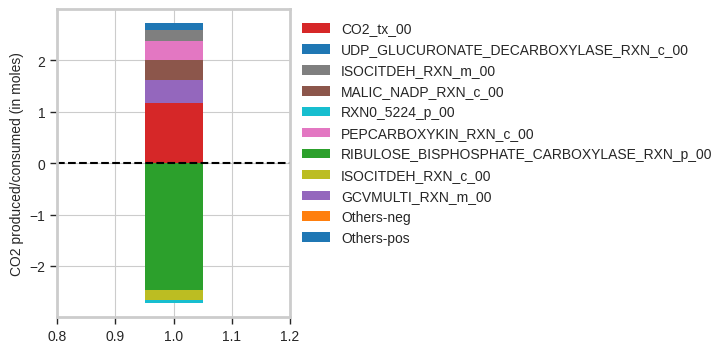

In [32]:
generateCO2budget(temp_model_no_EO_1A,solution_1A,outfile="",show_plot=True,percentage=False,day_or_night_tag="_00",save_plot_to="temp.png",colourDict={})


Total: 1.157849819923546


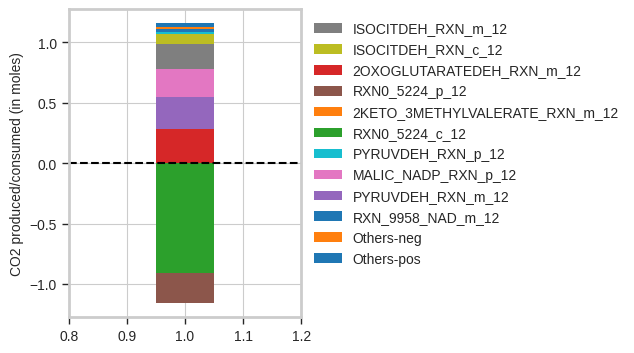

In [33]:
generateCO2budget(temp_model_no_EO_1A,solution_1A,outfile="",show_plot=True,percentage=False,day_or_night_tag="_12",save_plot_to="temp.png",colourDict={})


##### with "discouraging CO2 refixation"

Total: 1.664687549997472


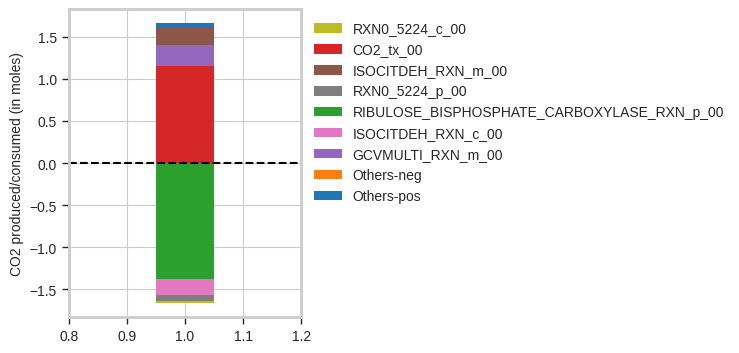

In [34]:
generateCO2budget(temp_model_with_EO_1B,solution_1B,outfile="",show_plot=True,percentage=False,day_or_night_tag="_00",save_plot_to="temp.png",colourDict={})


Total: 0.8906299714057563


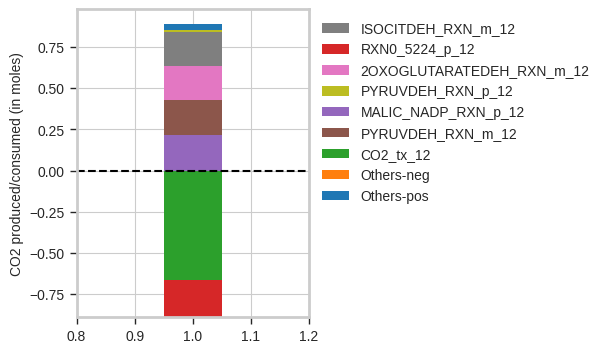

In [35]:
generateCO2budget(temp_model_with_EO_1B,solution_1B,outfile="",show_plot=True,percentage=False,day_or_night_tag="_12",save_plot_to="temp.png",colourDict={})


### CO2 scan

In [36]:
dataframes_list = []
expt_CO2_assim_range = [0,0]
expt_growth_rate_range = [0,0]

start_value = 0.5
end_value = 7.0
interval = 0.2

#### CO2 scan without discouraging CO2 refixation

In [37]:
temp_model_A = marchantia_model.copy()
model = temp_model_A

model.reactions.get_by_id(objective_reaction).upper_bound = 1000


df_A, solution_dict_A= parameter_scan_CO2(model, objective_reaction, "CO2_tx_00", start_value, end_value, interval, pFBA = pFBA_or_not, CO2_refixation_allowed=True, verbose=True, iterations=200)
dataframes_list.append(df_A)

Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0.5 (CO2_tx_00) --------
Objective: Marchantia_Naomi_minus_starch_tx_total
Model iteration feasible. Objective flux: 0.1072111
----- Cytosol -----
producing HCO3-:	RXN0_5224_c_12	0.88669
consuming CO2:	RXN0_5224_c_12	0.88669
producing CO2:	CO2_pc_12	0.009427
producing CO2:	ISOCITDEH_RXN_c_12	0.08196
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.004642
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000126
producing CO2:	CO2_mc_12	0.790535
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.88669
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00037
producing CO2:	RXN_9652_p_12	0.001061
producing CO2:	RXN_9650_p_12	0.001061
producing CO2:	2_PERIOD_3_PERIOD_1_PERIOD_180_RXN_p_12	0.001061
producing CO2:	RXN_9654_p_12	0.001061
producing HCO3-:	RXN0_5224_p_12	0.22473
consuming CO2:	RXN0_5224_p_12	0.22473
consuming CO2:	CO2_pc_12	0.009427
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.008287
producing CO2:	MA

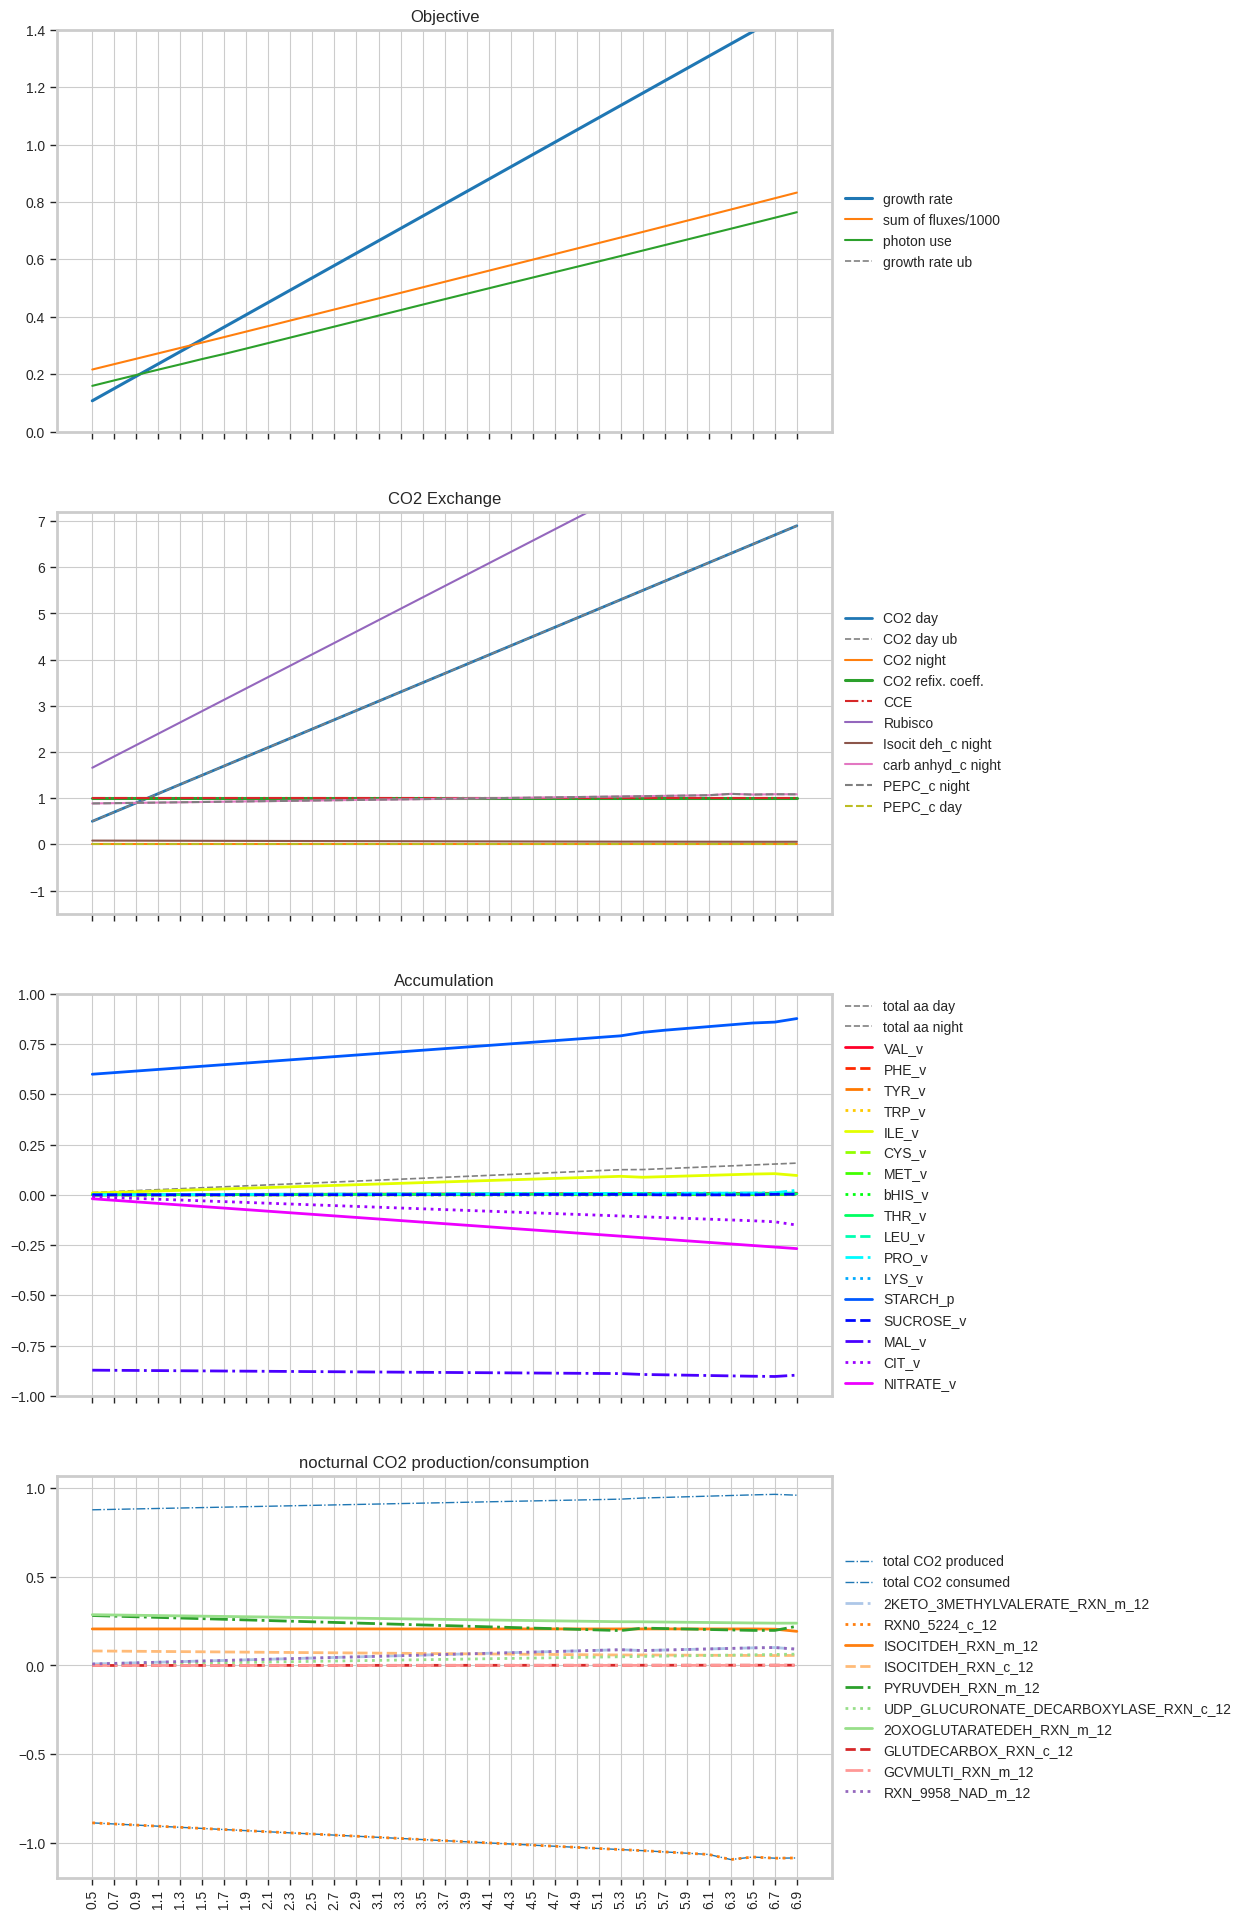

In [38]:
plot_accum(df_A, 0.0001, expt_growth_rate_range, expt_CO2_assim_range, lim5_x = -1,lim5_y = 1, CO2_organelle=["_c", "_m"])

#### CO2 scan with discouraging CO2 refixation

In [39]:
temp_model_B = marchantia_model.copy()
model = temp_model_B

model.reactions.get_by_id(objective_reaction).upper_bound = 1000


df_B, solution_dict_B= parameter_scan_CO2(model, objective_reaction, "CO2_tx_00", start_value, end_value, interval, pFBA = pFBA_or_not, CO2_refixation_allowed=False, verbose=True, iterations=200)
dataframes_list.append(df_B)

Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0.5 (CO2_tx_00) --------
Model can achieve desired CO2 rate, without discouraging CO2 refixation.
0.10721106584261775
First optimisation: Model is feasible.
Starting CO2 uptake = 11.124185971464
Starting output flux: Marchantia_Naomi_minus_starch_tx_total = 2.120066924352843


---- CO2 adjustment iteration 1 ----
CCE: 88.88
Factor: 0.0449
prev: 2.120066924352843
now: 0.09529087925135755
Vc flux = 1.315391296871306
Current CO2 uptake = 1.1089617701205212
Target CO2 uptake = 0.5
Output_ID before: 2.120066924352843
Output_ID after: 0.09529087925135755
CCE: 40.07
Sum of fluxes: 142.02772169019428


---- CO2 adjustment iteration 2 ----
CCE: 40.07
Factor: 0.4509
prev: 0.09529087925135755
now: 0.0429640055314988
Vc flux = 1.014341770613345
Current CO2 uptake = 0.8510570349058201
Target CO2 uptake = 0.5
Output_ID before: 0.09529087925135755
Output_ID after: 0.0429640055314988
CCE: 23.54
Sum of fluxes: 118.88373985227284



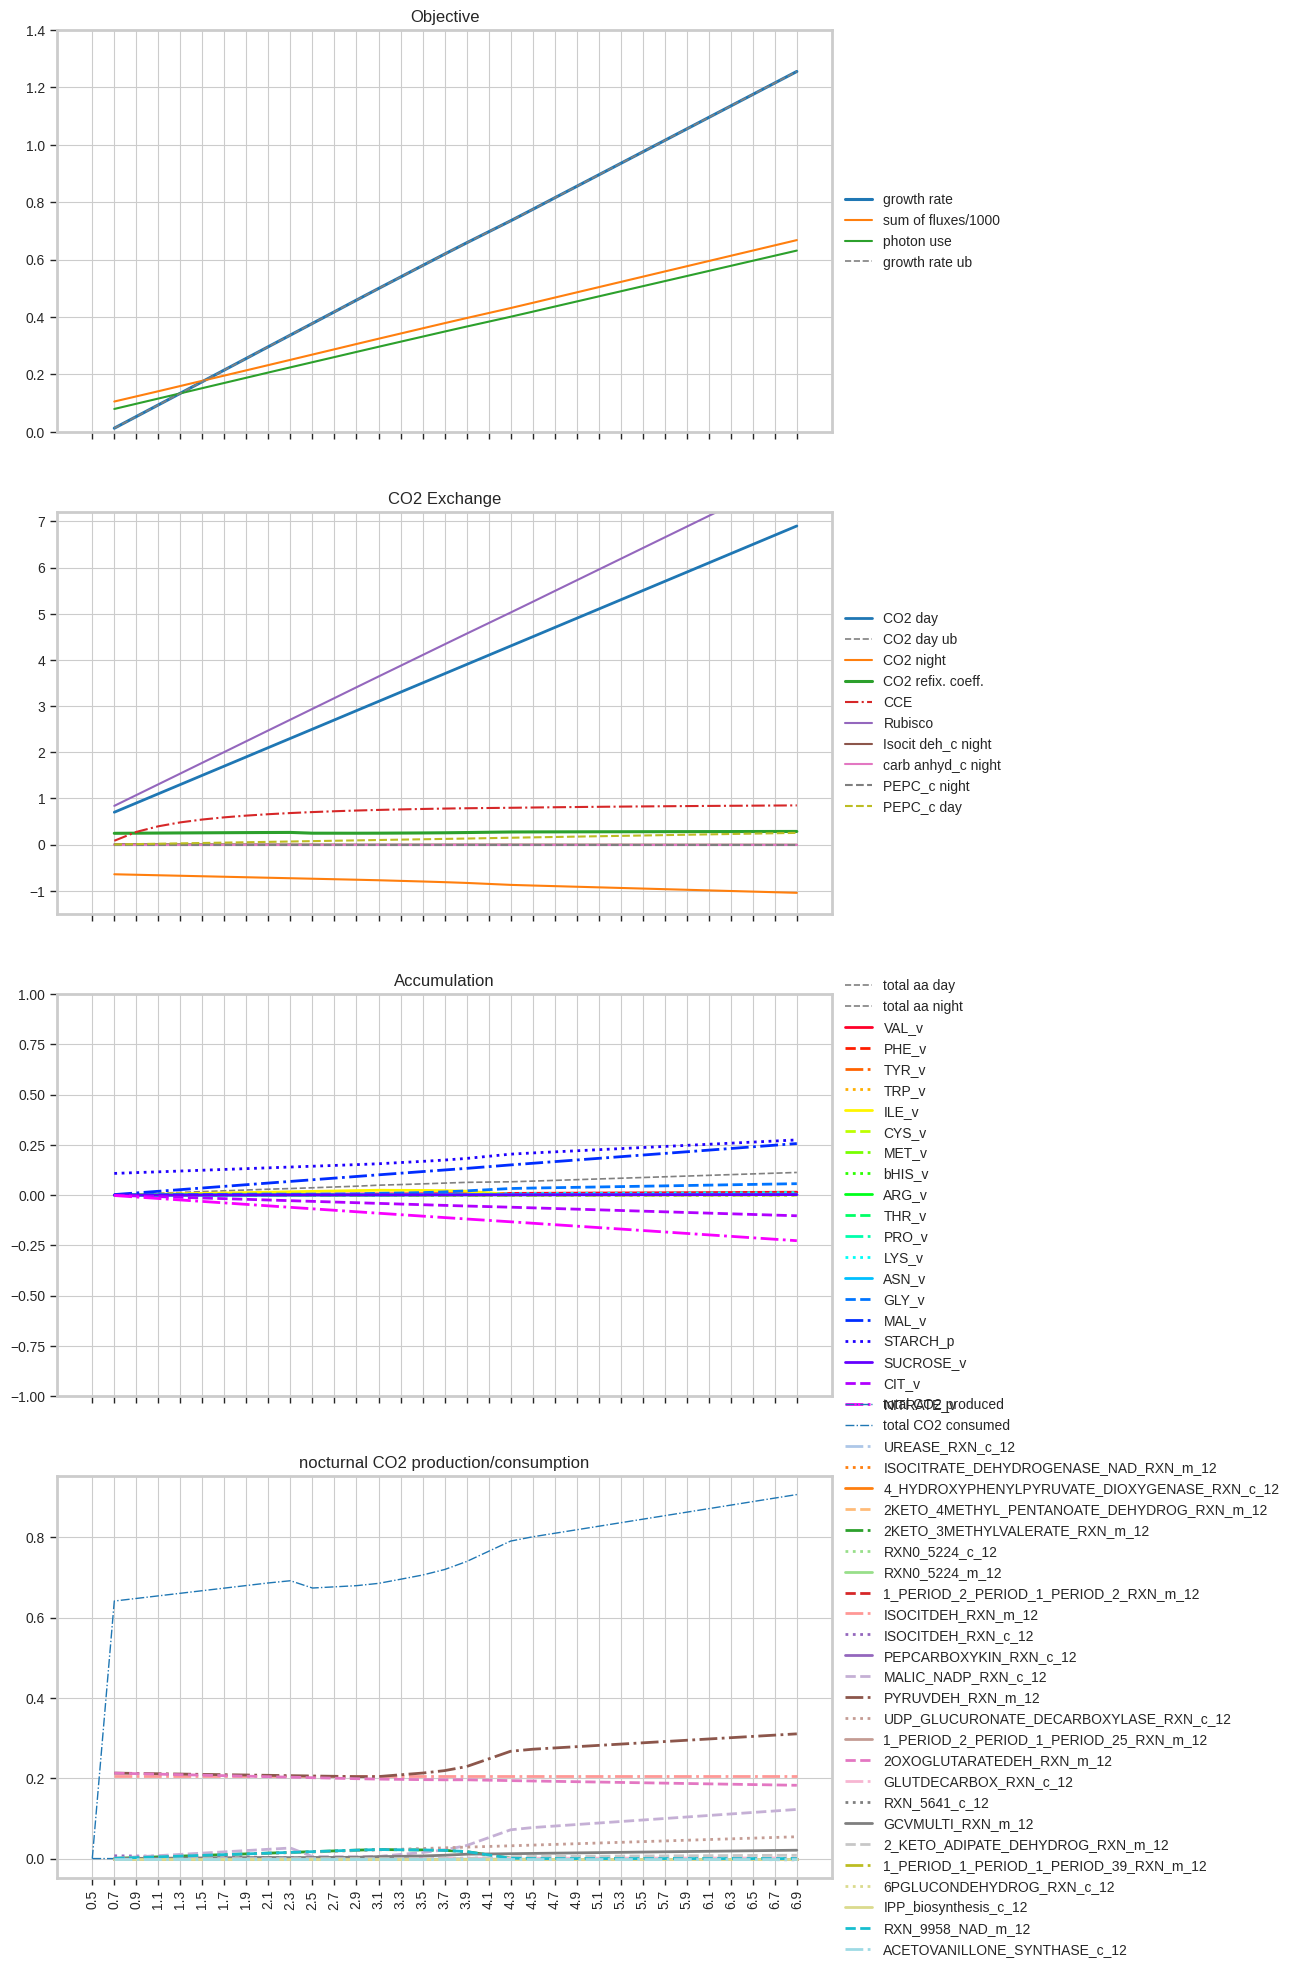

In [40]:
plot_accum(df_B, 0.0001, expt_growth_rate_range, expt_CO2_assim_range, lim5_x = -1,lim5_y = 1, CO2_organelle=["_c", "_m"])

# Applying experimental data

In [41]:
marchantia_model_expt = marchantia_model.copy()

In [42]:
expt_CO2_assim = 1.86
expt_CO2_resp = -0.7

marchantia_model_expt.reactions.CO2_tx_00.upper_bound = expt_CO2_assim

marchantia_model_expt.reactions.CO2_tx_12.lower_bound = expt_CO2_resp
marchantia_model_expt.reactions.CO2_tx_12.upper_bound = expt_CO2_resp

marchantia_model_expt.reactions.MAL_v_linker_12_to_00.upper_bound = 0
# marchantia_model_expt.reactions.CIT_v_linker_12_to_00.upper_bound = 

In [43]:
marchantia_model_expt.reactions.CO2_tx_00

Reaction identifier,CO2_tx_00
Name,CO2_tx
Memory address,0x7fe2cb9cb220
Stoichiometry,<=> CARBON_DIOXIDE_e_00 <=> CARBON-DIOXIDE
GPR,
Lower bound,-1000.0
Upper bound,1.86


In [44]:
marchantia_model_expt.reactions.CO2_tx_12

Reaction identifier,CO2_tx_12
Name,CO2_tx
Memory address,0x7fe2edd19240
Stoichiometry,<-- CARBON_DIOXIDE_e_12 <-- CARBON-DIOXIDE
GPR,
Lower bound,-0.7
Upper bound,-0.7


with estimate Output

In [45]:
temp_model_C = marchantia_model_expt


solution_1C, temp_model_with_EO_1C = estimateOutputFromNetCO2_Corinna_dev(temp_model_C,expt_CO2_assim,Output_ID=objective_reaction,
                                      Vc_ID="RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_00",
                                      CO2in_ID="CO2_tx_00",verbose=True, iterations=40, threshold = 0.0001)

temp_model_with_EO_1C.reactions.get_by_id(objective_reaction).flux
model_results_overview(temp_model_with_EO_1C, solution_1C)
calculate_noct_CO2_refixation_coefficient(temp_model_with_EO_1C, verbose=True)

Model can achieve desired CO2 rate, without discouraging CO2 refixation.
0.2487296727548724
First optimisation: Model is feasible.
Starting CO2 uptake = 10.530940483024695
Starting output flux: Marchantia_Naomi_minus_starch_tx_total = 2.1079712148408385


---- CO2 adjustment iteration 1 ----
CCE: 93.35
Factor: 0.1766
prev: 2.1079712148408385
now: 0.37231493862529363
Vc flux = 2.90585577098935
Current CO2 uptake = 2.436364318828055
Target CO2 uptake = 1.86
Output_ID before: 2.1079712148408385
Output_ID after: 0.37231493862529363
CCE: 71.27
Sum of fluxes: 267.21702606793036


---- CO2 adjustment iteration 2 ----
CCE: 71.27
Factor: 0.7634
prev: 0.37231493862529363
now: 0.28423736979375763
Vc flux = 2.399451651871239
Current CO2 uptake = 2.025597164620169
Target CO2 uptake = 1.86
Output_ID before: 0.37231493862529363
Output_ID after: 0.28423736979375763
CCE: 65.44
Sum of fluxes: 227.0366616039165


---- CO2 adjustment iteration 3 ----
CCE: 65.44
Factor: 0.9182
prev: 0.28423736979375763
now

0.25903050641985736

without estimate Output

In [46]:
temp_model_D = marchantia_model_expt
objective_reaction =  "Marchantia_Naomi_minus_starch_tx_total"


solution_1D, temp_model_no_EO_1D = optimise_model(temp_model_D, objective_reaction)


print("Sum of fluxes:", solution_1D.objective_value)
print(temp_model_no_EO_1D.reactions.get_by_id(objective_reaction).flux)
print(temp_model_no_EO_1D.reactions.CO2_tx_12.flux)
model_results_overview(temp_model_no_EO_1D, solution_1D)

calculate_noct_CO2_refixation_coefficient(temp_model_no_EO_1D, verbose = True)

Objective: Marchantia_Naomi_minus_starch_tx_total
Sum of fluxes: 210.958264534082
0.24872967275487143
-0.7
Photon uptake = 32.2105    % of allowed Photon uptake = 18.51
growth rate = 0.2487 		sum of fluxes: 210.9583
gas exchange = Day: 1.86 	Night: -0.7
CCE: 62.37
ATPase:  1.854 1.854
Rubisco Carbox./Oxygen. =  2.1944 / 0.7315
Linker fluxes 		 Day 	 Night
GLN_v_linker                         0.0       0.0
VAL_v_linker                     0.00283       0.0
PHE_v_linker                     0.00049       0.0
TYR_v_linker                     0.00032       0.0
L_ALPHA_ALANINE_v_linker         0       0.0
SER_v_linker                         0.0       0.0
TRP_v_linker                     0.00013       0.0
GLT_v_linker                 0       0.0
ILE_v_linker                      0.0163       0.0
L_ASPARTATE_v_linker         0       0.0
CYS_v_linker                     0.00026       0.0
MET_v_linker                     0.00034       0.0
bHIS_v_linker                    0.00029       0.0
ARG_v

0.25902994019025954

In [47]:
#constraining Citrate accumulation to experimental estimate

temp_model_D = marchantia_model_expt
objective_reaction =  "Marchantia_Naomi_minus_starch_tx_total"

temp_model_D.reactions.CIT_v_linker_12_to_00.upper_bound = 0.0166


solution_1D, temp_model_no_EO_1D = optimise_model(temp_model_D, objective_reaction)


print("Sum of fluxes:", solution_1D.objective_value)
print(temp_model_no_EO_1D.reactions.get_by_id(objective_reaction).flux)
print(temp_model_no_EO_1D.reactions.CO2_tx_12.flux)
model_results_overview(temp_model_no_EO_1D, solution_1D)

calculate_noct_CO2_refixation_coefficient(temp_model_no_EO_1D, verbose = True)

Objective: Marchantia_Naomi_minus_starch_tx_total
Sum of fluxes: 211.00068792445128
0.24872967275487257
-0.7
Photon uptake = 32.2247    % of allowed Photon uptake = 18.52
growth rate = 0.2487 		sum of fluxes: 211.0007
gas exchange = Day: 1.86 	Night: -0.7
CCE: 62.37
ATPase:  1.854 1.854
Rubisco Carbox./Oxygen. =  2.1955 / 0.7318
Linker fluxes 		 Day 	 Night
GLN_v_linker                         0.0       0.0
VAL_v_linker                     0.00283       0.0
PHE_v_linker                     0.00049       0.0
TYR_v_linker                     0.00032       0.0
L_ALPHA_ALANINE_v_linker         0       0.0
SER_v_linker                         0.0       0.0
TRP_v_linker                     0.00013       0.0
GLT_v_linker                 0       0.0
ILE_v_linker                     0.01372       0.0
L_ASPARTATE_v_linker         0       0.0
CYS_v_linker                     0.00026       0.0
MET_v_linker                     0.00034       0.0
bHIS_v_linker                    0.00029       0.0
ARG

0.26004170774223695

Scans


In [48]:
dataframes_list = []
expt_CO2_assim_range = [0,0]
expt_growth_rate_range = [0,0]

start_value = 0.0
end_value = 3
interval = 0.2

In [49]:
temp_model_E = marchantia_model_expt
model = temp_model_E

model.reactions.get_by_id(objective_reaction).upper_bound = 1000


df_E, solution_dict_E= parameter_scan_CO2(model, objective_reaction, "CO2_tx_00", start_value, end_value, interval, pFBA = pFBA_or_not, CO2_refixation_allowed=True, verbose=True, iterations=200)
dataframes_list.append(df_E)

Scanning process: CO2_tx_00 



------- Scan iteration: 1      Scan value: 0.0 (CO2_tx_00) --------
Objective: Marchantia_Naomi_minus_starch_tx_total
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 0.2 (CO2_tx_00) --------
Objective: Marchantia_Naomi_minus_starch_tx_total
Model iteration is infeasible!
------- Scan iteration: 3      Scan value: 0.4 (CO2_tx_00) --------
Objective: Marchantia_Naomi_minus_starch_tx_total
Model iteration is infeasible!
------- Scan iteration: 4      Scan value: 0.6000000000000001 (CO2_tx_00) --------
Objective: Marchantia_Naomi_minus_starch_tx_total
Model iteration is infeasible!
------- Scan iteration: 5      Scan value: 0.8 (CO2_tx_00) --------
Objective: Marchantia_Naomi_minus_starch_tx_total
Model iteration feasible. Objective flux: 0.0214422
----- Cytosol -----
producing CO2:	CO2_pc_12	0.002369
producing CO2:	ISOCITDEH_RXN_c_12	0.010501
producing CO2:	CO2_xc_12	0.000136
producing CO2:	MALIC_NADP_RXN_c_12	0.044703
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE

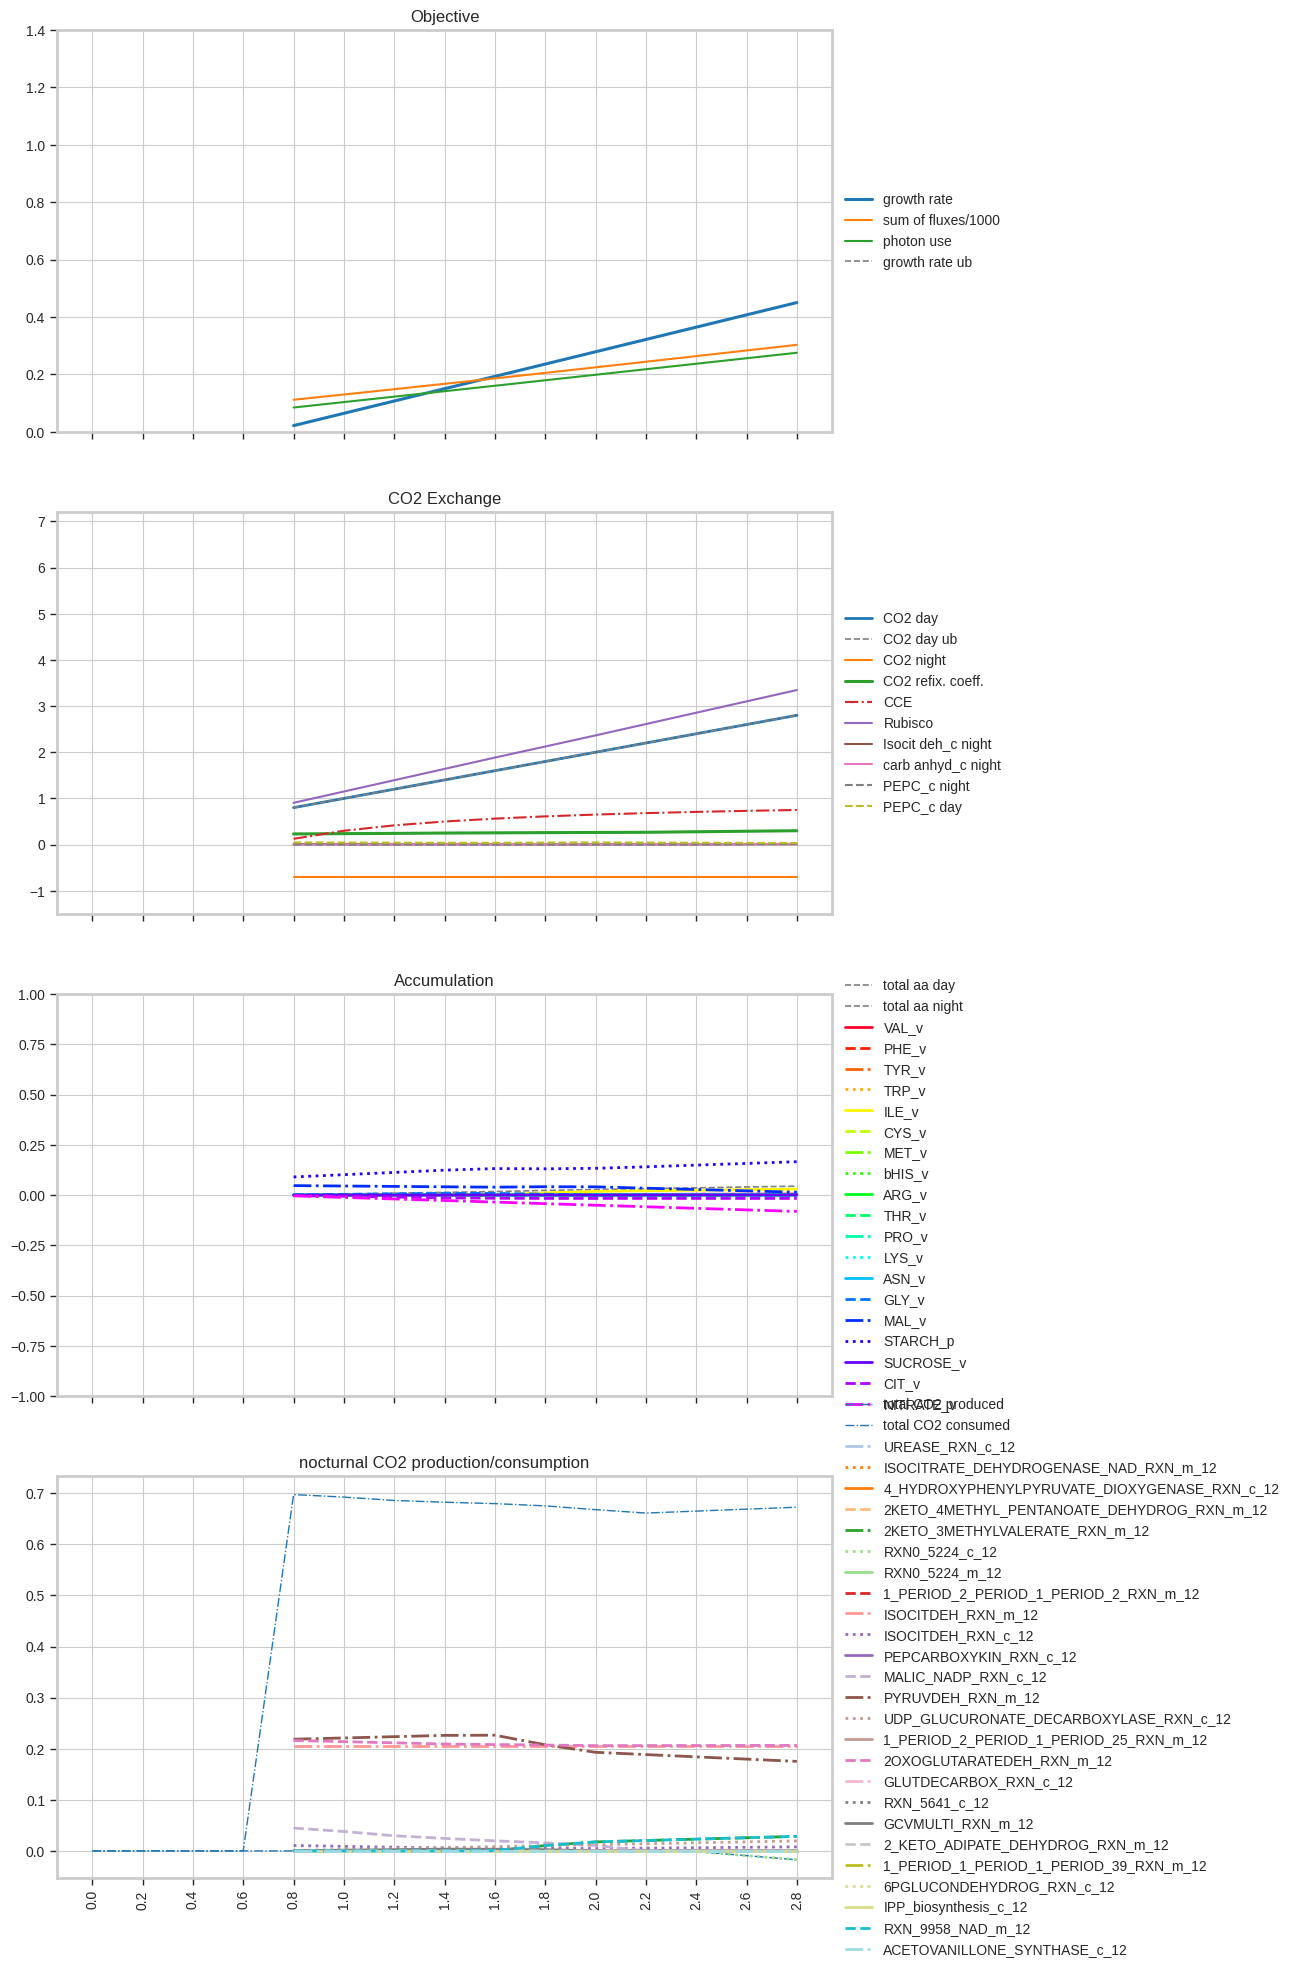

In [50]:
plot_accum(df_E, 0.0001, expt_growth_rate_range, expt_CO2_assim_range, lim5_x = -1,lim5_y = 1, CO2_organelle=["_c", "_m"])

#### CO2 scan with discouraging CO2 refixation

In [51]:
temp_model_F = marchantia_model_expt
model = temp_model_F

model.reactions.get_by_id(objective_reaction).upper_bound = 1000


df_F, solution_dict_F= parameter_scan_CO2(model, objective_reaction, "CO2_tx_00", start_value, end_value, interval, pFBA = pFBA_or_not, CO2_refixation_allowed=False, verbose=True, iterations=200)
dataframes_list.append(df_F)

Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0.0 (CO2_tx_00) --------

Model cannot achieve desired CO2 rate, even without discouraging CO2 refixation!
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 0.2 (CO2_tx_00) --------

Model cannot achieve desired CO2 rate, even without discouraging CO2 refixation!
Model iteration is infeasible!
------- Scan iteration: 3      Scan value: 0.4 (CO2_tx_00) --------

Model cannot achieve desired CO2 rate, even without discouraging CO2 refixation!
Model iteration is infeasible!
------- Scan iteration: 4      Scan value: 0.6000000000000001 (CO2_tx_00) --------

Model cannot achieve desired CO2 rate, even without discouraging CO2 refixation!
Model iteration is infeasible!
------- Scan iteration: 5      Scan value: 0.8 (CO2_tx_00) --------
Model can achieve desired CO2 rate, without discouraging CO2 refixation.
0.021442213168522965
First optimisation: Model is feasible.
Starting CO2 uptake = 3.403277

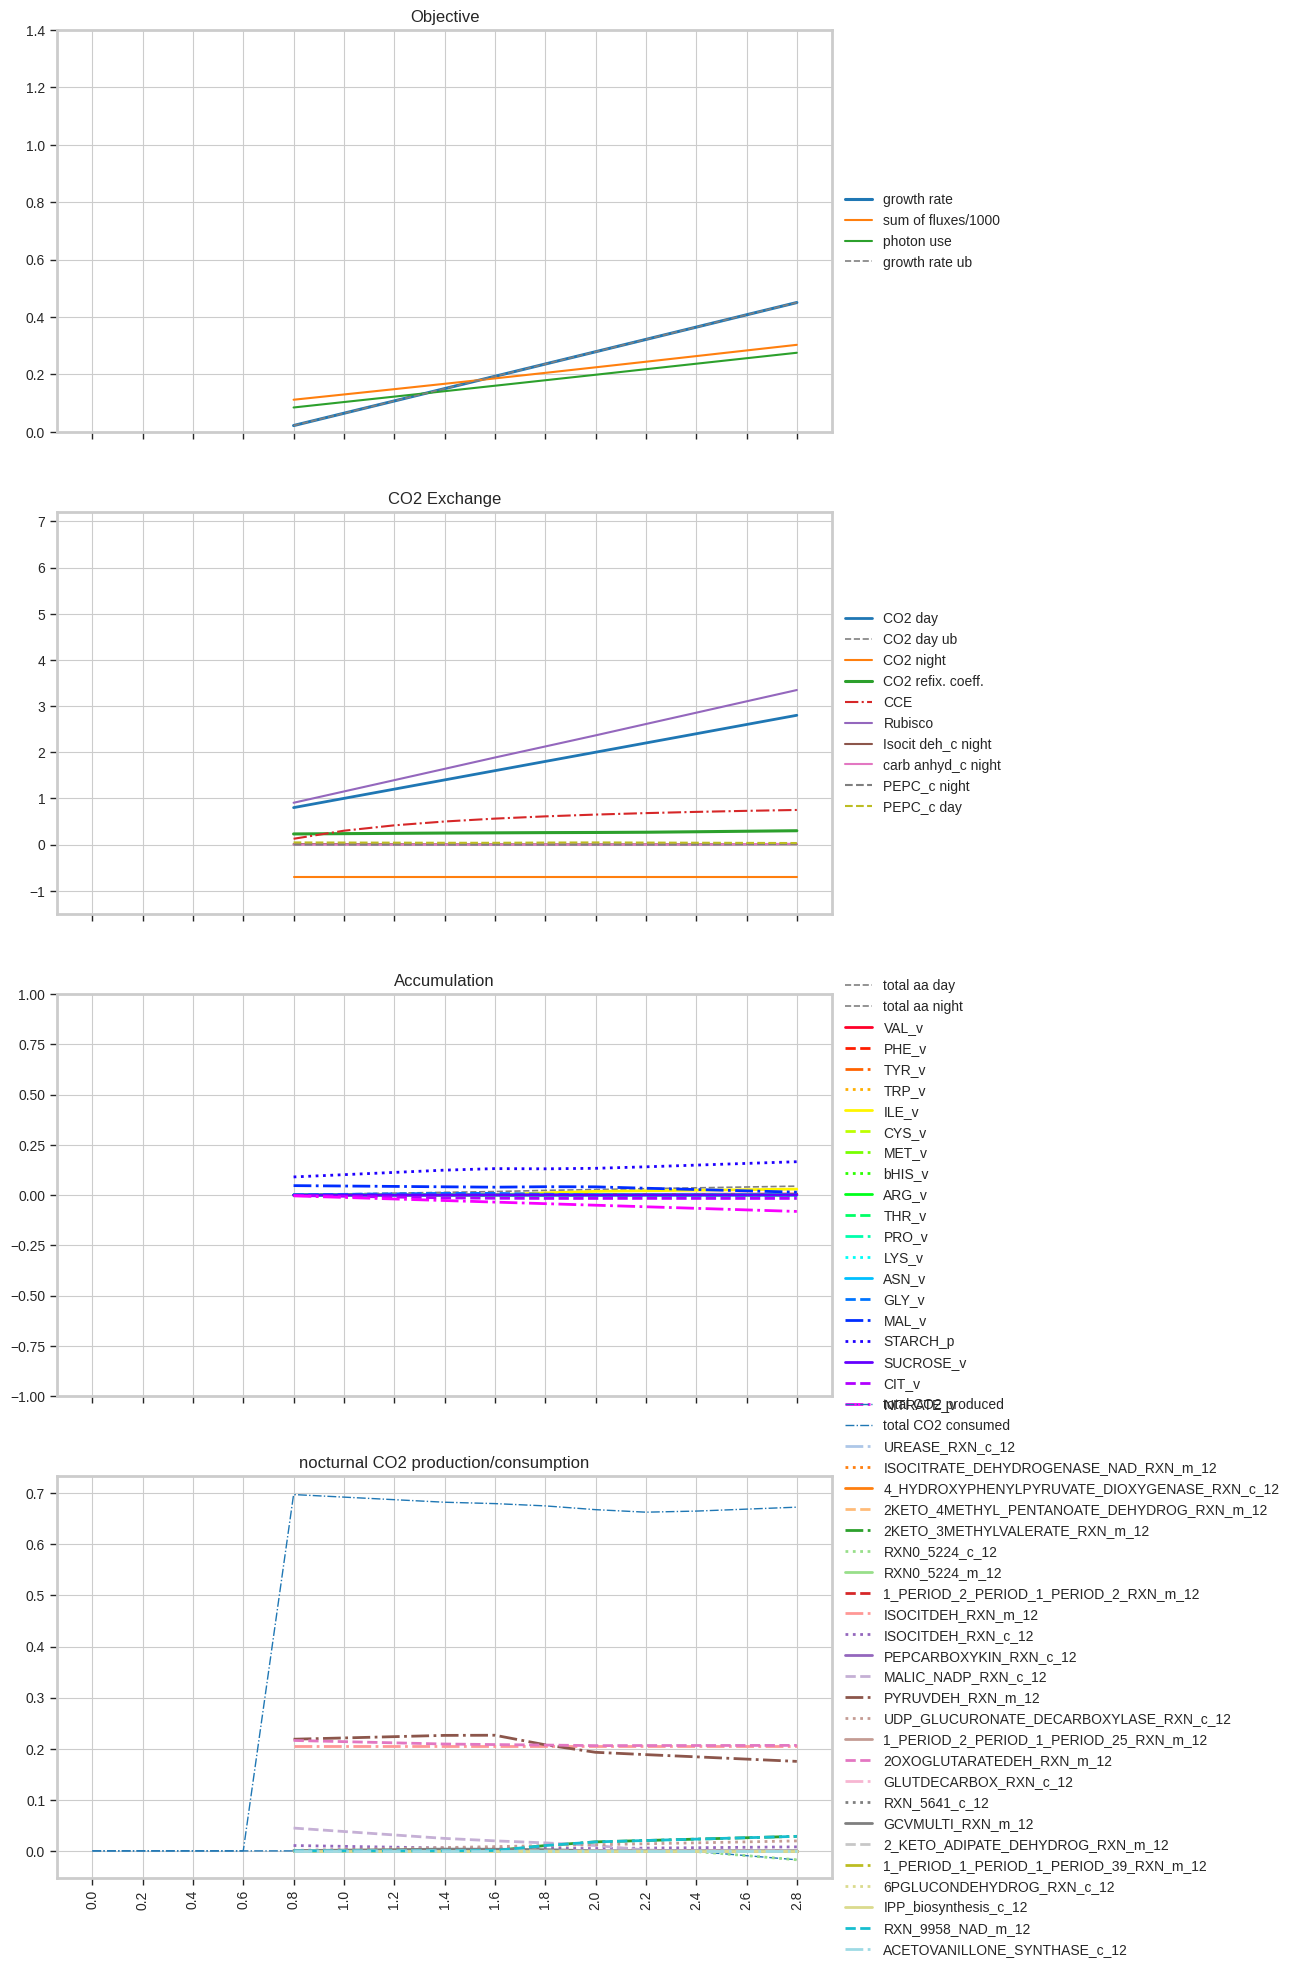

In [52]:
plot_accum(df_F, 0.0001, expt_growth_rate_range, expt_CO2_assim_range, lim5_x = -1,lim5_y = 1, CO2_organelle=["_c", "_m"])

In [53]:
models = [temp_model_no_EO_1A, temp_model_with_EO_1B, temp_model_D]

model = temp_model_no_EO_1A
#

rxns = [
        "Photon_tx_00",
        "CO2_tx_00",
        "CO2_tx_12",
        "O2_tx_00",
        "O2_tx_12",
        "RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_00",
        "RXN_961_p_00",
        "STARCH_p_linker_00_to_12",
        "MAL_v_linker_00_to_12",
        "MAL_v_linker_12_to_00",
        "CIT_v_linker_00_to_12",
        "CIT_v_linker_12_to_00",
        "Nitrate_tx_00",
        "Nitrate_tx_12",
        "NITRATE_v_linker_12_to_00",
        "AraCore_Biomass_tx_00",
        "AraCore_Biomass_tx_12",
        "Marchantia_Naomi_minus_starch_tx_light",
        "Marchantia_Naomi_minus_starch_tx_dark",
        "Marchantia_Naomi_minus_starch_tx_total",
        "ATPase_tx_00",
        "PEPCARBOX_RXN_c_12",
        "PEPCARBOX_RXN_p_12",
        "RXN0_5224_c_12",
        "RXN0_5224_p_12",
        "PYRUVDEH_RXN_p_12",
        "PYRUVDEH_RXN_m_12",
        "ISOCITDEH_RXN_c_12",
        "ISOCITDEH_RXN_x_12",
        "ISOCITDEH_RXN_m_12",
        "Mitochondrial_ATP_Synthase_m_00",
        "Mitochondrial_ATP_Synthase_m_12",
        "PEPCARBOXYKIN_RXN_c_00",
        # "ATP_CITRATE_PRO_S__LYASE_RXN_c_00",
        # "ATP_CITRATE_PRO_S__LYASE_RXN_c_12",
        "CITSYN_RXN_m_12",
        "ACONITATEDEHYDR_RXN_c_12",
        "ACONITATEDEHYDR_RXN_c_00",
        "GLUTAMINESYN_RXN_p_00",
        # "FERREDOXIN__NITRITE_REDUCTASE_RXN_p_00",
        "GCVMULTI_RXN_m_00",
        "Plastidial_ATP_Synthase_p_00",
        "PSII_RXN_p_00",
        # "1.18.1.2_RXN_p_00",
        "NADH_DEHYDROG_A_RXN_mc_12",
        "GAPOXNPHOSPHN_RXN_c_12",
        "GAPOXNPHOSPHN_RXN_p_12",
        "GLU6PDEHYDROG_RXN_c_12",
        "GLU6PDEHYDROG_RXN_x_12",
        "GLU6PDEHYDROG_RXN_p_12",
        "6PGLUCONDEHYDROG_RXN_c_12",
        "6PGLUCONDEHYDROG_RXN_p_12",
        "6PGLUCONDEHYDROG_RXN_x_12",
        "2OXOGLUTARATEDEH_RXN_m_12",
        "MALIC_NADP_RXN_c_00",
        "GLUTDECARBOX_RXN_c_00",
        "PEPDEPHOS_RXN_c_12",
        "PEPDEPHOS_RXN_p_12",
        "ACETYL_COA_ACETYLTRANSFER_RXN_m_12",
        "ACETYL_COA_ACETYLTRANSFER_RXN_x_12",
        "BHBDCLOS_RXN_x_12",
        "3_HYDROXBUTYRYL_COA_DEHYDRATASE_RXN_x_12",
        "GLUTACONYL_COA_DECARBOXYLASE_RXN_x_12",
        "ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_00",
        "MALATE_DEH_RXN_c_00",
        "MALATE_DEH_RXN_x_00",
        "MALATE_DEH_RXN_m_00",
        "MALATE_DEH_RXN_p_00",
        "MALATE_DEHYDROGENASE_NADP_RXN_p_00"

]


for rxn in rxns:
        print(rxn, "\t", round(model.reactions.get_by_id(rxn).flux, 4))
        # print(round(model.reactions.get_by_id(rxn).flux, 4))



Photon_tx_00 	 38.5971
CO2_tx_00 	 1.1648
CO2_tx_12 	 0.0
O2_tx_00 	 -2.3804
O2_tx_12 	 0.9319
RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_00 	 2.4768
RXN_961_p_00 	 0.8256
STARCH_p_linker_00_to_12 	 0.627
MAL_v_linker_00_to_12 	 0.0
MAL_v_linker_12_to_00 	 0.8751
CIT_v_linker_00_to_12 	 0.0
CIT_v_linker_12_to_00 	 0.0231
Nitrate_tx_00 	 0.0678
Nitrate_tx_12 	 0.0452
NITRATE_v_linker_12_to_00 	 0.0452
AraCore_Biomass_tx_00 	 0.0
AraCore_Biomass_tx_12 	 0.0
Marchantia_Naomi_minus_starch_tx_light 	 0.1873
Marchantia_Naomi_minus_starch_tx_dark 	 0.0624
Marchantia_Naomi_minus_starch_tx_total 	 0.2497
ATPase_tx_00 	 1.854
PEPCARBOX_RXN_c_12 	 0.9075
PEPCARBOX_RXN_p_12 	 0.2303
RXN0_5224_c_12 	 0.9075
RXN0_5224_p_12 	 0.2496
PYRUVDEH_RXN_p_12 	 0.0218
PYRUVDEH_RXN_m_12 	 0.2698
ISOCITDEH_RXN_c_12 	 0.0788
ISOCITDEH_RXN_x_12 	 0.0
ISOCITDEH_RXN_m_12 	 0.206
Mitochondrial_ATP_Synthase_m_00 	 0.5245
Mitochondrial_ATP_Synthase_m_12 	 1.1172
PEPCARBOXYKIN_RXN_c_00 	 0.3693
CITSYN_RXN_m_12 	 0.3088
AC

In [54]:
marchantia_model.reactions.MALATE_DEH_RXN_c_00

Reaction identifier,MALATE_DEH_RXN_c_00
Name,MALATE-DEH-RXN:Malate dehydrogenase
Memory address,0x7fe2f4469e70
Stoichiometry,MAL_c_00 + NAD_c_00 <=> NADH_c_00 + OXALACETIC_ACID_c_00 + PROTON_c_00 MAL + NAD <=> NADH + OXALACETIC_ACID[c] + PROTON
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [55]:
models = [temp_model_no_EO_1A, temp_model_with_EO_1B, temp_model_D]

model = temp_model_no_EO_1A


for rxn in model.reactions:
    if "linker" in rxn.id:
        print(rxn.id, "\t", round(rxn.flux, 4))
        # print(round(rxn.flux, 4))


GLN_v_linker_00_to_12 	 0.0
VAL_v_linker_00_to_12 	 0.0014
PHE_v_linker_00_to_12 	 0.0005
TYR_v_linker_00_to_12 	 0.0003
L_ALPHA_ALANINE_v_linker_00_to_12 	 0.0
SER_v_linker_00_to_12 	 0.0
TRP_v_linker_00_to_12 	 0.0001
GLT_v_linker_00_to_12 	 0.0
ILE_v_linker_00_to_12 	 0.0203
L_ASPARTATE_v_linker_00_to_12 	 0.0
CYS_v_linker_00_to_12 	 0.0003
MET_v_linker_00_to_12 	 0.0003
bHIS_v_linker_00_to_12 	 0.0003
ARG_v_linker_00_to_12 	 0.0
THR_v_linker_00_to_12 	 0.0009
LEU_v_linker_00_to_12 	 0.0015
PRO_v_linker_00_to_12 	 0.0016
LYS_v_linker_00_to_12 	 0.0
ASN_v_linker_00_to_12 	 0.0
GLY_v_linker_00_to_12 	 0.0
FUM_v_linker_00_to_12 	 0.0
SUC_v_linker_00_to_12 	 0.0
MAL_v_linker_00_to_12 	 0.0
CIT_v_linker_00_to_12 	 0.0
STARCH_p_linker_00_to_12 	 0.627
SUCROSE_v_linker_00_to_12 	 0.0005
GLC_v_linker_00_to_12 	 0.0
FRU_v_linker_00_to_12 	 0.0
NITRATE_v_linker_00_to_12 	 0.0
GLN_v_linker_12_to_00 	 0.0
VAL_v_linker_12_to_00 	 0.0
PHE_v_linker_12_to_00 	 0.0
TYR_v_linker_12_to_00 	 0.0
L_ALPH

In [56]:
models = [temp_model_no_EO_1A, temp_model_with_EO_1B, temp_model_D]
solutions = [solution_1A, solution_1B, solution_1D]

i = 0
model = models[i]
solution = solutions[i]

In [57]:
 _, df_temp = generateMetaboliteBudget(model, solution, show_plot=True, percentage=False, 
                        day_or_night_tag="_00", 
                         metabolite="PHOSPHO_ENOL_PYRUVATE_", threshold=0.005)

NameError: name 'generateMetaboliteBudget' is not defined

In [ ]:
temp_model_with_EO_1B

In [ ]:
marchantia_model.reactions.get_by_id("MALATE_DEHYDROGENASE_NADP_RXN_p_00")

Reaction identifier,MALATE_DEHYDROGENASE_NADP_RXN_p_00
Name,MALATE-DEHYDROGENASE-NADP-RXN
Memory address,0x7f0e4a28ddb0
Stoichiometry,NADPH_p_00 + OXALACETIC_ACID_p_00 + PROTON_p_00 --> MAL_p_00 + NADP_p_00 NADPH + OXALACETIC_ACID[p] + PROTON --> MAL + NADP
GPR,
Lower bound,0.0
Upper bound,1000.0


In [ ]:
marchantia_model.reactions.get_by_id("3PGAREARR_RXN_c_12")

Reaction identifier,3PGAREARR_RXN_c_12
Name,3PGAREARR-RXN:Phosphoglycerate mutase
Memory address,0x7f0e4a051090
Stoichiometry,G3P_c_12 <=> 2_PG_c_12 G3P <=> 2-PG
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [ ]:
marchantia_model.metabolites.get_by_id("2_PG_c_12")

Metabolite identifier,2_PG_c_12
Name,2-PG
Memory address,0x7f0e4a41eb00
Formula,C3H4O7P1
Compartment,c_12
In 2 reaction(s),"3PGAREARR_RXN_c_12, 2PGADEHYDRAT_RXN_c_12"
